# Dự đoán khả năng mắc bệnh tiểu đường

## Bài tập lớn môn Nhập môn Học máy và Khai phá dữ liệu

Tập dữ liệu: [Diabetes Prediction Dataset](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset/data)

Mục tiêu: Xây dựng mô hình học máy để dự đoán khả năng mắc bệnh tiểu đường dựa trên các đặc trưng như tuổi, giới tính, chỉ số BMI, mức đường huyết, v.v.

Các bước thực hiện:
1. Thu thập và đọc dữ liệu
2. Trực quan hóa dữ liệu
3. Tiền xử lý dữ liệu
4. Huấn luyện mô hình
5. Đánh giá mô hình

Khai báo các thư viện sử dụng

In [ ]:
# Nhập các thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
import xgboost as xgb
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.combine import SMOTEENN
import time
import os

# Thiết lập style cho biểu đồ
sns.set(style="whitegrid")
%matplotlib inline

Nhập vào dữ liệu

In [ ]:
# Đọc dữ liệu
data = pd.read_csv('/content/drive/MyDrive/GG Colab/Diabetes/diabetes_prediction_dataset.csv')

# Hiển thị thông tin cơ bản
print("Thông tin dữ liệu:")
print(data.info())
print("\nMẫu dữ liệu đầu tiên:")
print(data.head())

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None

Mẫu dữ liệu đầu tiên:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Mal

In [ ]:
data.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


Mã hóa các biến phân loại

In [ ]:
# Tiền xử lý dữ liệu ban đầu
def preprocess_data(data):
    # Mã hóa biến phân loại
    le = LabelEncoder()
    data['gender'] = le.fit_transform(data['gender'])
    data['smoking_history'] = le.fit_transform(data['smoking_history'])

    # Loại bỏ giá trị bất thường (bmi > 60)
    data = data[data['bmi'] <= 60]

    return data

# Áp dụng tiền xử lý
data_processed = preprocess_data(data.copy())
print("Dữ liệu sau khi tiền xử lý ban đầu:")
print(data_processed.head())

Dữ liệu sau khi tiền xử lý ban đầu:
   gender   age  hypertension  heart_disease  smoking_history    bmi  \
0       0  80.0             0              1                4  25.19   
1       0  54.0             0              0                0  27.32   
2       1  28.0             0              0                4  27.32   
3       0  36.0             0              0                1  23.45   
4       1  76.0             1              1                1  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  


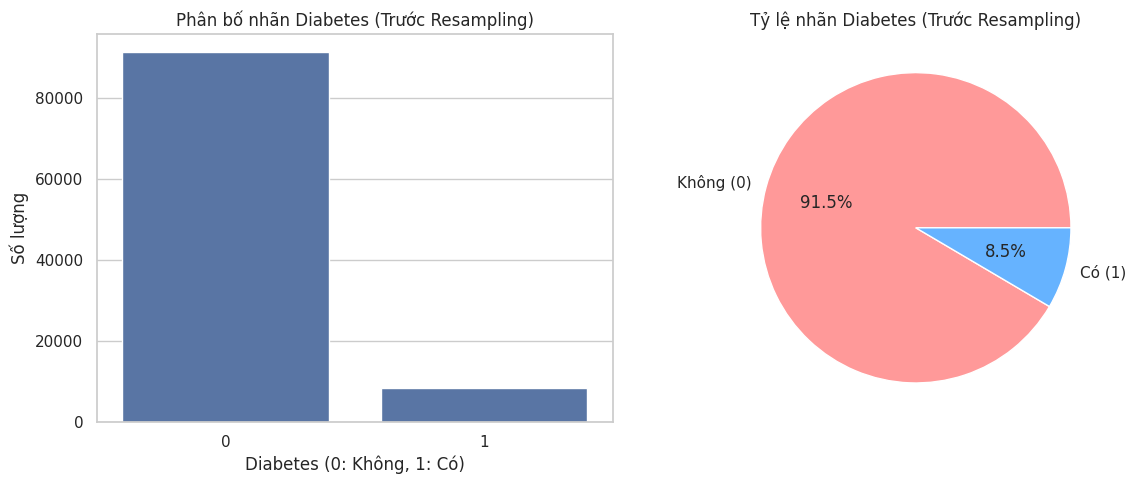

Tỷ lệ lớp trước resampling:
diabetes
0    0.915273
1    0.084727
Name: count, dtype: float64


In [ ]:
# Phân bố nhãn trước resampling
plt.figure(figsize=(12, 5))

# Biểu đồ cột
plt.subplot(1, 2, 1)
sns.countplot(x='diabetes', data=data_processed)
plt.title('Phân bố nhãn Diabetes (Trước Resampling)')
plt.xlabel('Diabetes (0: Không, 1: Có)')
plt.ylabel('Số lượng')

# Biểu đồ tròn
plt.subplot(1, 2, 2)
data_processed['diabetes'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Không (0)', 'Có (1)'], colors=['#ff9999', '#66b3ff'])
plt.title('Tỷ lệ nhãn Diabetes (Trước Resampling)')
plt.ylabel('')
plt.tight_layout()
plt.show()

# Tính tỷ lệ
class_counts = data_processed['diabetes'].value_counts()
print("Tỷ lệ lớp trước resampling:")
print(class_counts / len(data_processed))

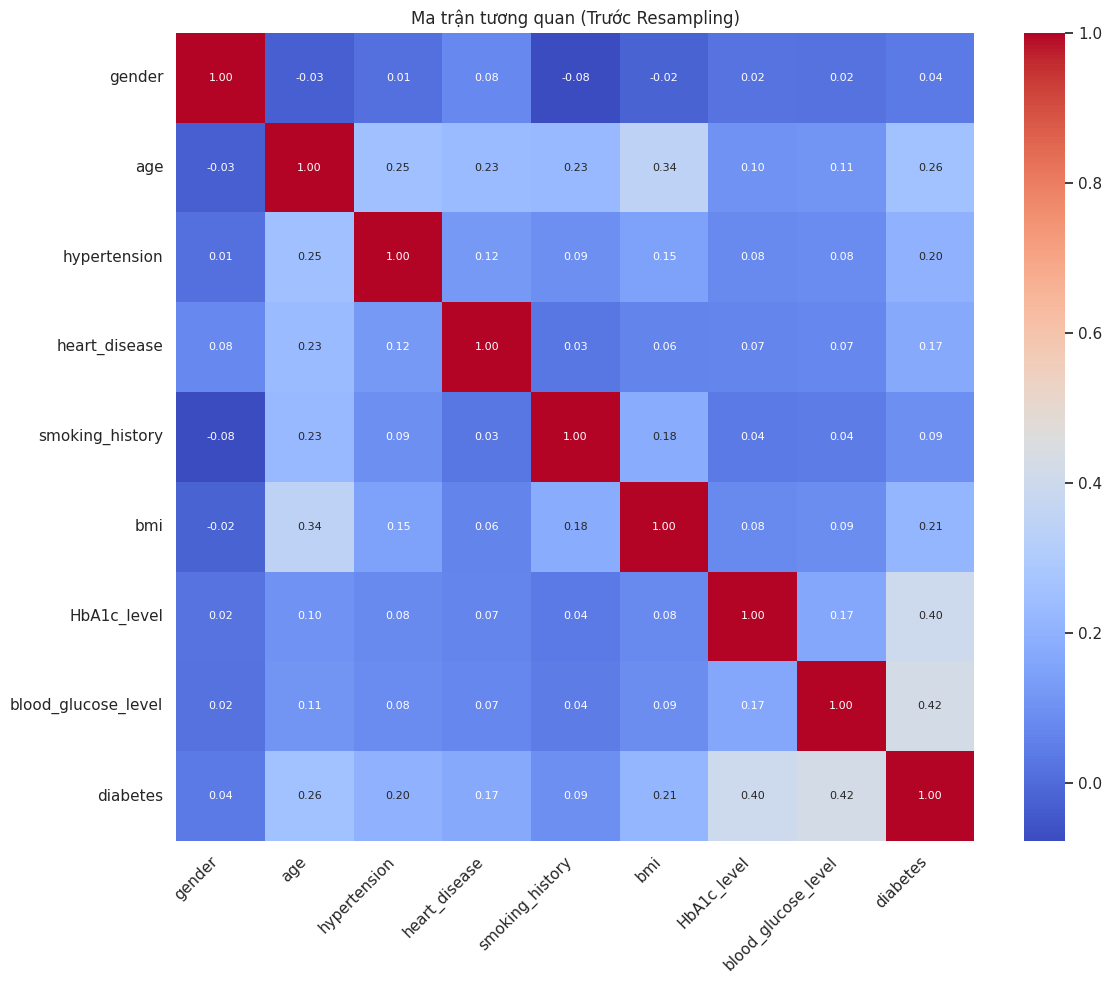

Các trường trong ma trận tương quan:
['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']


In [ ]:
# Ma trận tương quan trước resampling
plt.figure(figsize=(12, 10))  # Tăng kích thước để hiển thị rõ hơn
corr_matrix = data_processed.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8})
plt.title('Ma trận tương quan (Trước Resampling)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# In ra để kiểm tra các trường
print("Các trường trong ma trận tương quan:")
print(corr_matrix.columns.tolist())

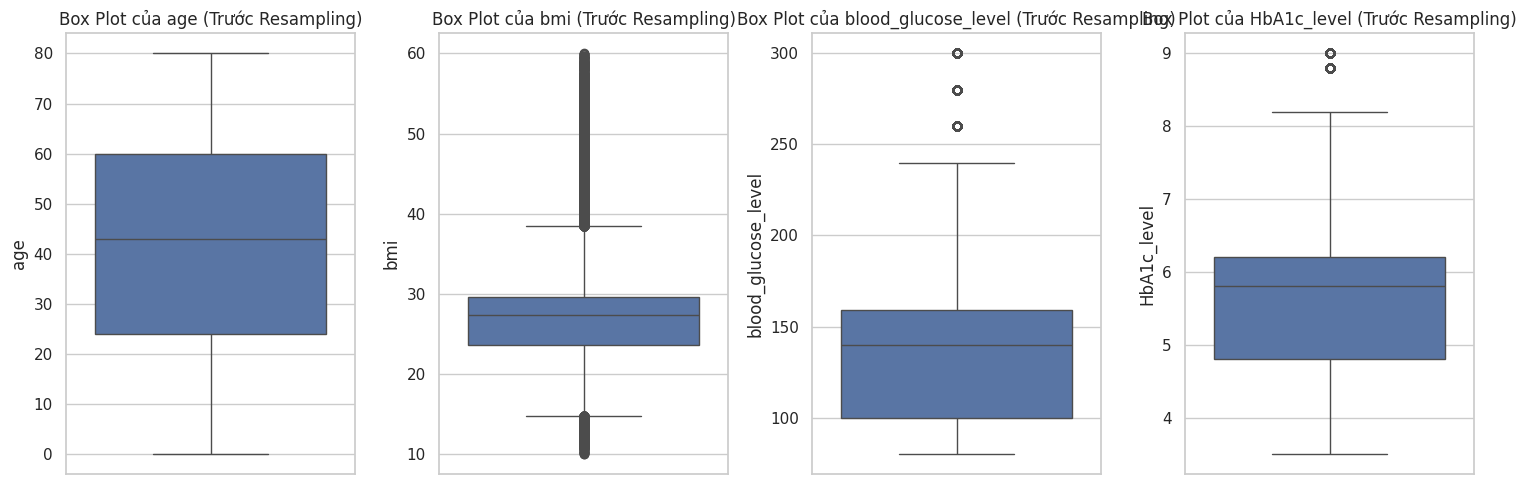

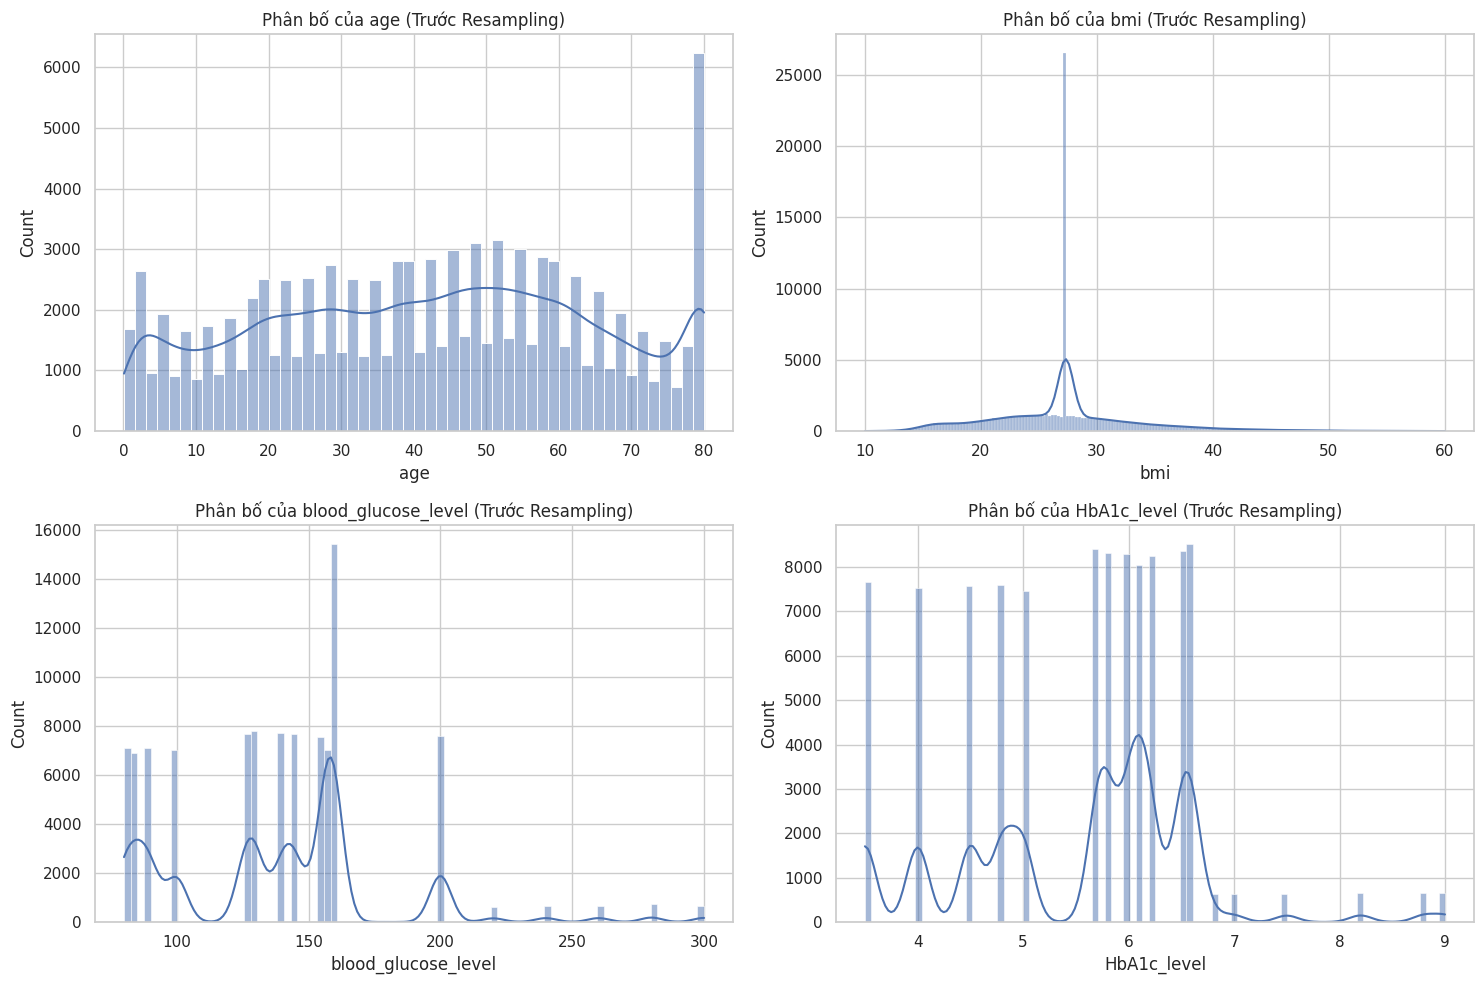

In [ ]:
# Các cột số
numerical_cols = ['age', 'bmi', 'blood_glucose_level', 'HbA1c_level']

# Box plot
plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(y=col, data=data_processed)
    plt.title(f'Box Plot của {col} (Trước Resampling)')
plt.tight_layout()
plt.show()

# Histogram
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data_processed[col], kde=True)
    plt.title(f'Phân bố của {col} (Trước Resampling)')
plt.tight_layout()
plt.show()

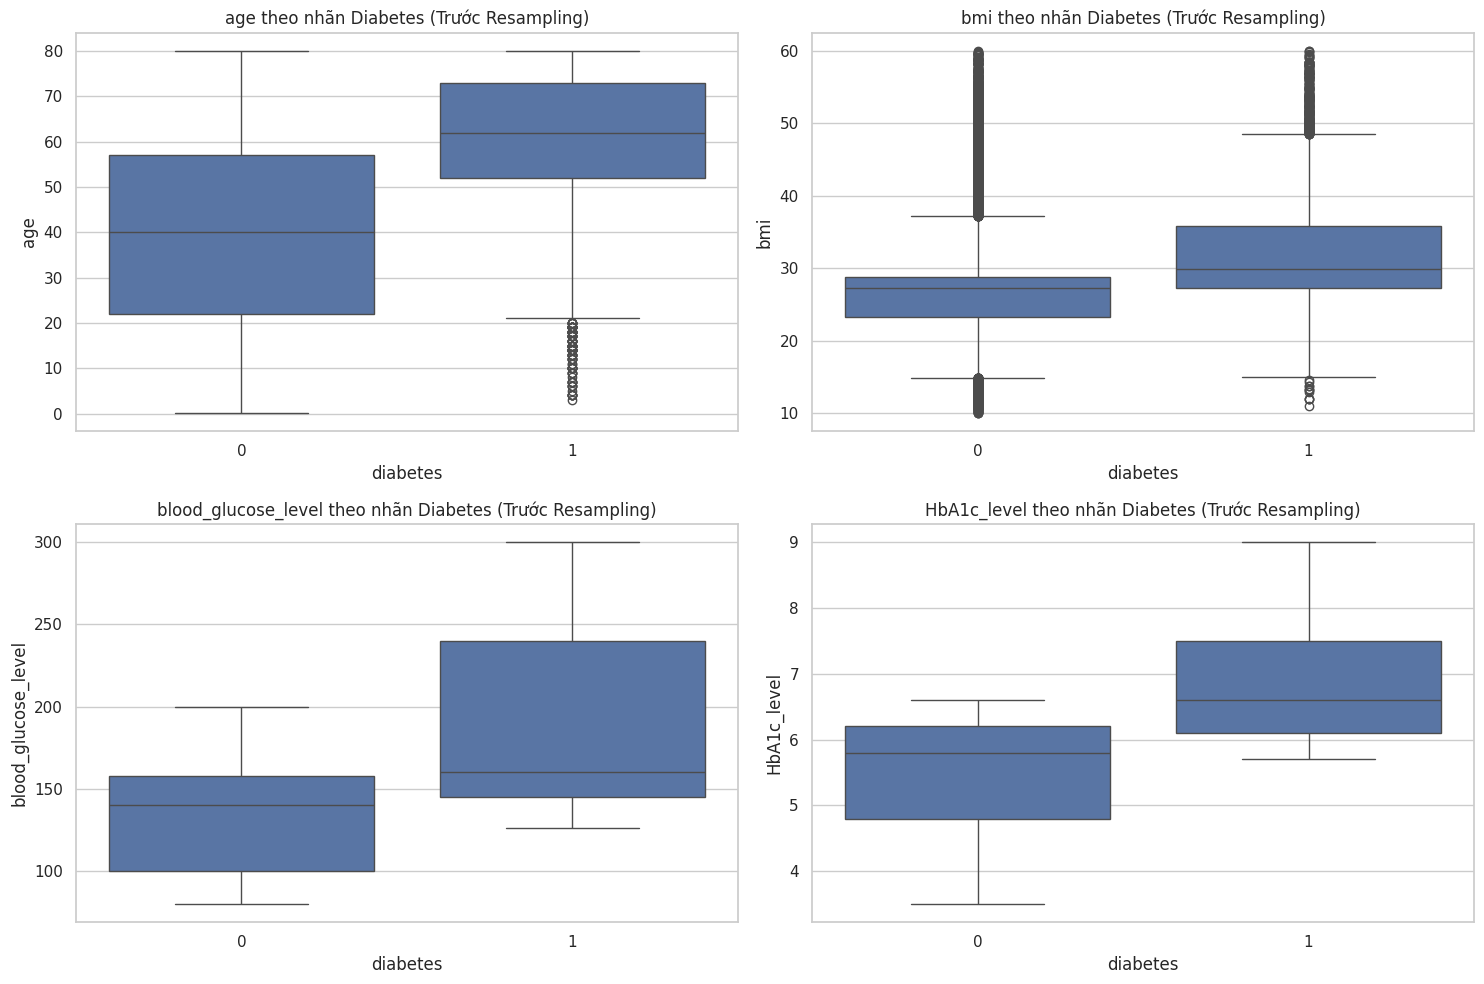

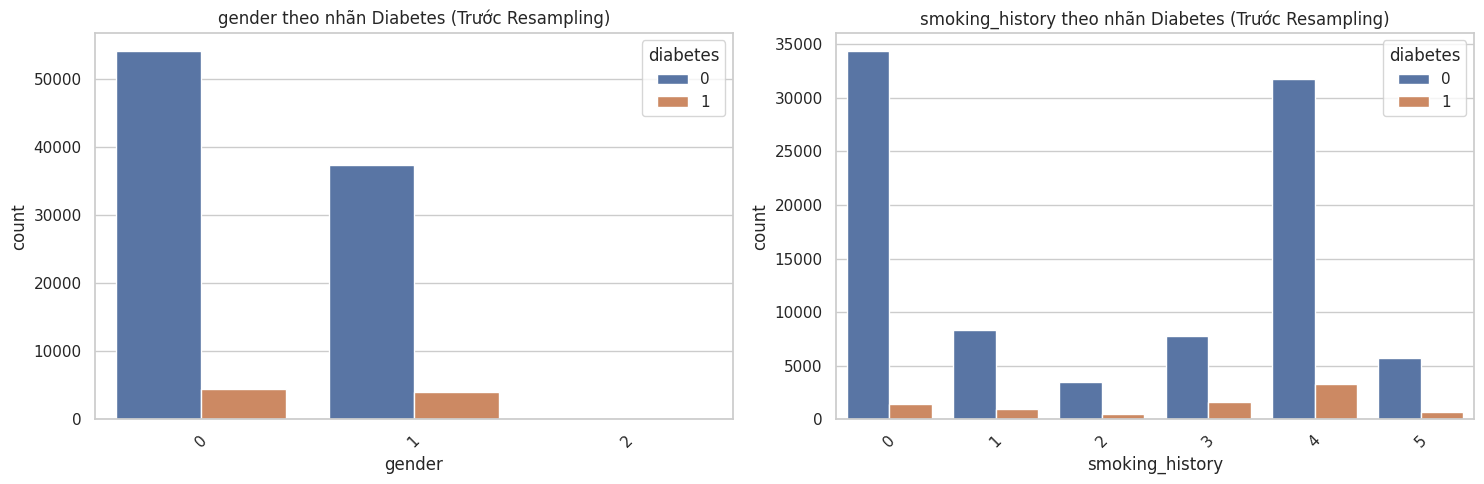

In [ ]:
# Mối quan hệ giữa đặc trưng số và nhãn
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='diabetes', y=col, data=data_processed)
    plt.title(f'{col} theo nhãn Diabetes (Trước Resampling)')
plt.tight_layout()
plt.show()

# Mối quan hệ giữa đặc trưng phân loại và nhãn
categorical_cols = ['gender', 'smoking_history']
plt.figure(figsize=(15, 5))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(1, 2, i)
    sns.countplot(x=col, hue='diabetes', data=data_processed)
    plt.title(f'{col} theo nhãn Diabetes (Trước Resampling)')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

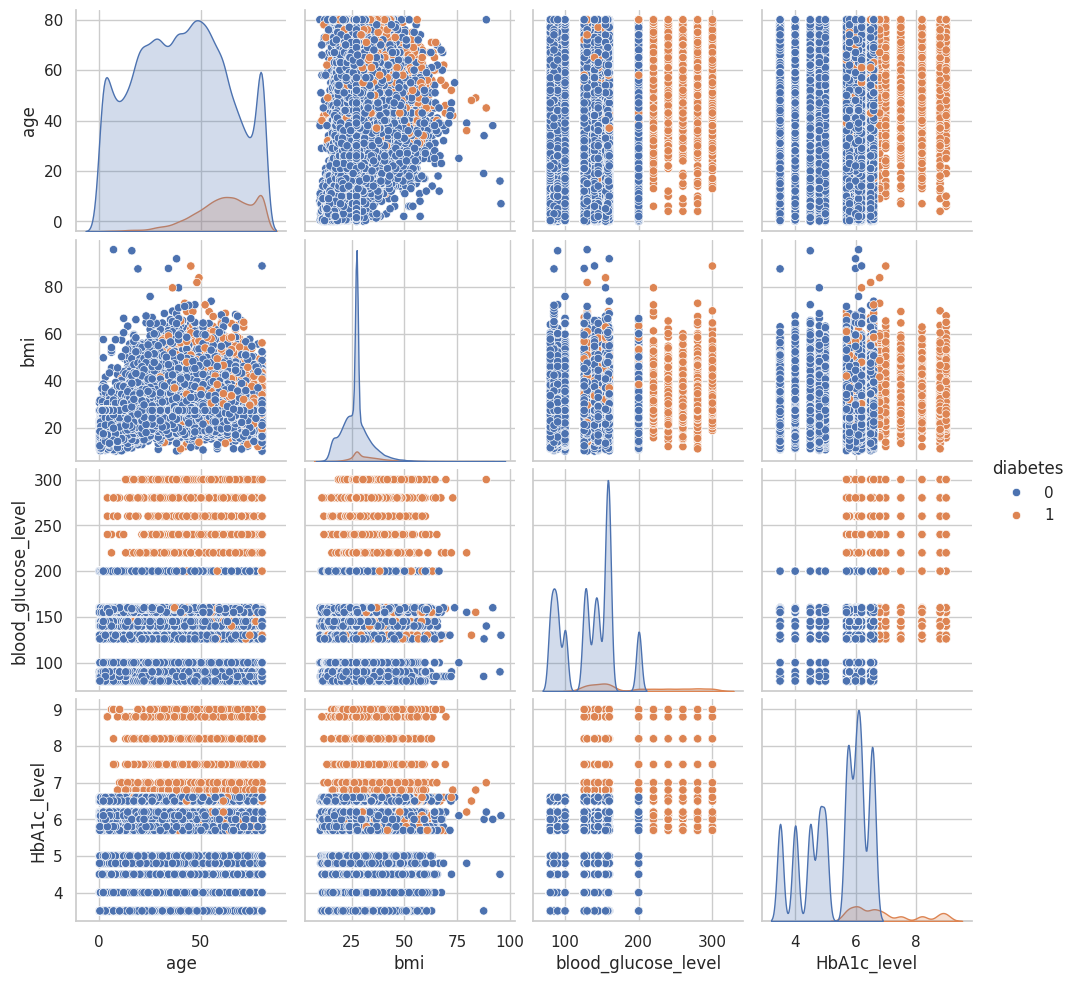

In [ ]:
sns.pairplot(data, hue='diabetes', vars=numerical_cols)

In [ ]:
# Hàm chia dữ liệu và chuẩn hóa
def split_and_standardize_data(data, test_size=0.2, random_state=42):
    X = data.drop('diabetes', axis=1)
    y = data['diabetes']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Chuẩn hóa dữ liệu sau khi chia
    scaler = StandardScaler()
    numerical_cols = ['age', 'bmi', 'blood_glucose_level', 'HbA1c_level']
    X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

    return X_train, X_test, y_train, y_test, scaler

# Chia dữ liệu
X_train_base, X_test, y_train_base, y_test, scaler = split_and_standardize_data(data_processed)
print("Kích thước tập train:", X_train_base.shape)
print("Kích thước tập test:", X_test.shape)

Kích thước tập train: (79908, 8)
Kích thước tập test: (19977, 8)


In [ ]:
# Hàm áp dụng resampling
def apply_resampling(X_train, y_train, method='smote', random_state=42):
    if method == 'none':  # Trước resampling
        return X_train, y_train
    elif method == 'smote':
        sampler = SMOTE(random_state=random_state)
    elif method == 'smote-enn':
        sampler = SMOTEENN(random_state=random_state)
    elif method == 'borderline-smote':
        sampler = BorderlineSMOTE(random_state=random_state)
    else:
        raise ValueError("Phương pháp resampling không hợp lệ.")

    X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

# Các trạng thái dữ liệu
states = ['none', 'smote', 'smote-enn', 'borderline-smote']
data_states = {}

# Áp dụng resampling cho từng trạng thái
for state in states:
    print(f"\nÁp dụng phương pháp: {state}")
    X_train_res, y_train_res = apply_resampling(X_train_base, y_train_base, method=state)
    data_states[state] = (X_train_res, y_train_res)


Áp dụng phương pháp: none

Áp dụng phương pháp: smote

Áp dụng phương pháp: smote-enn

Áp dụng phương pháp: borderline-smote



=== Trực Quan Hóa Dữ Liệu: NONE ===


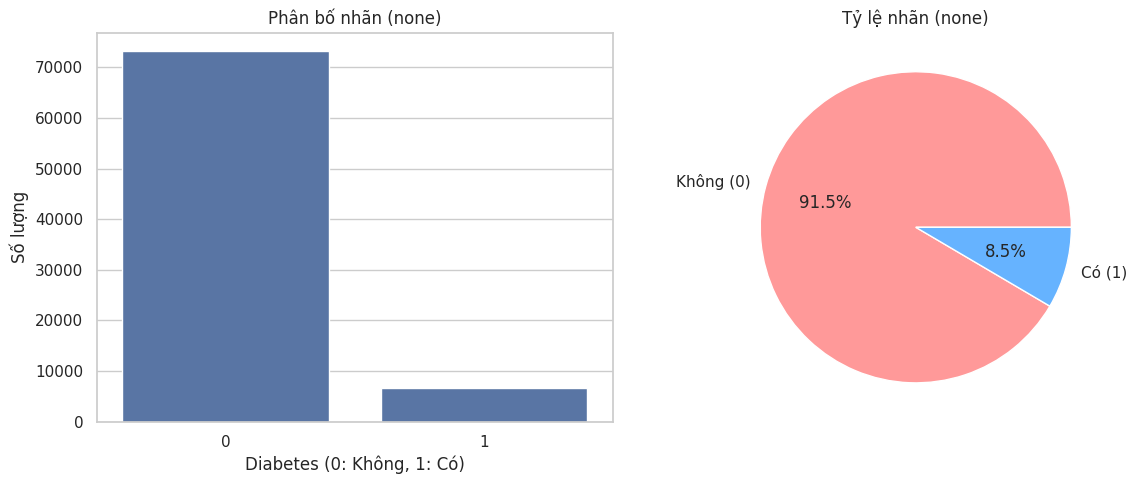

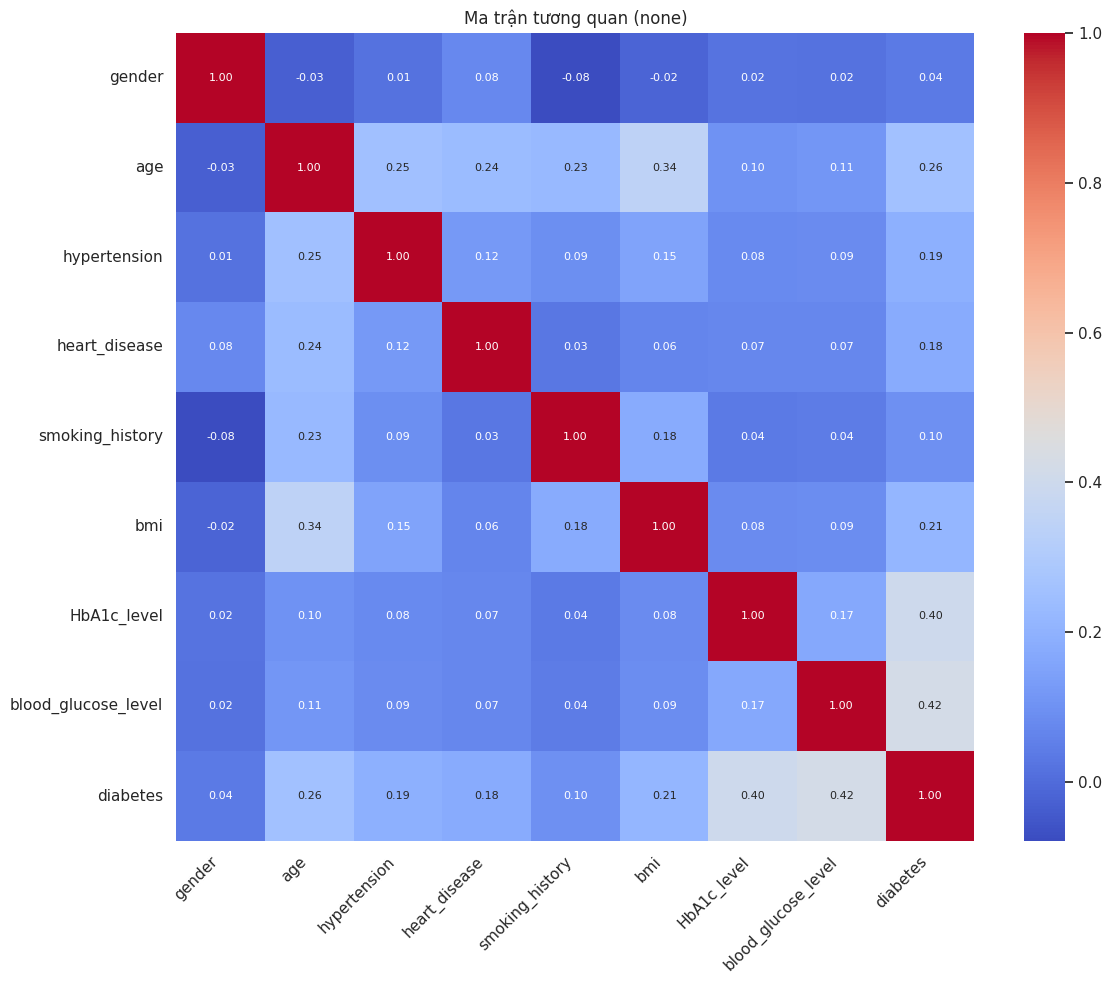

Các trường trong ma trận tương quan (none):
['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']


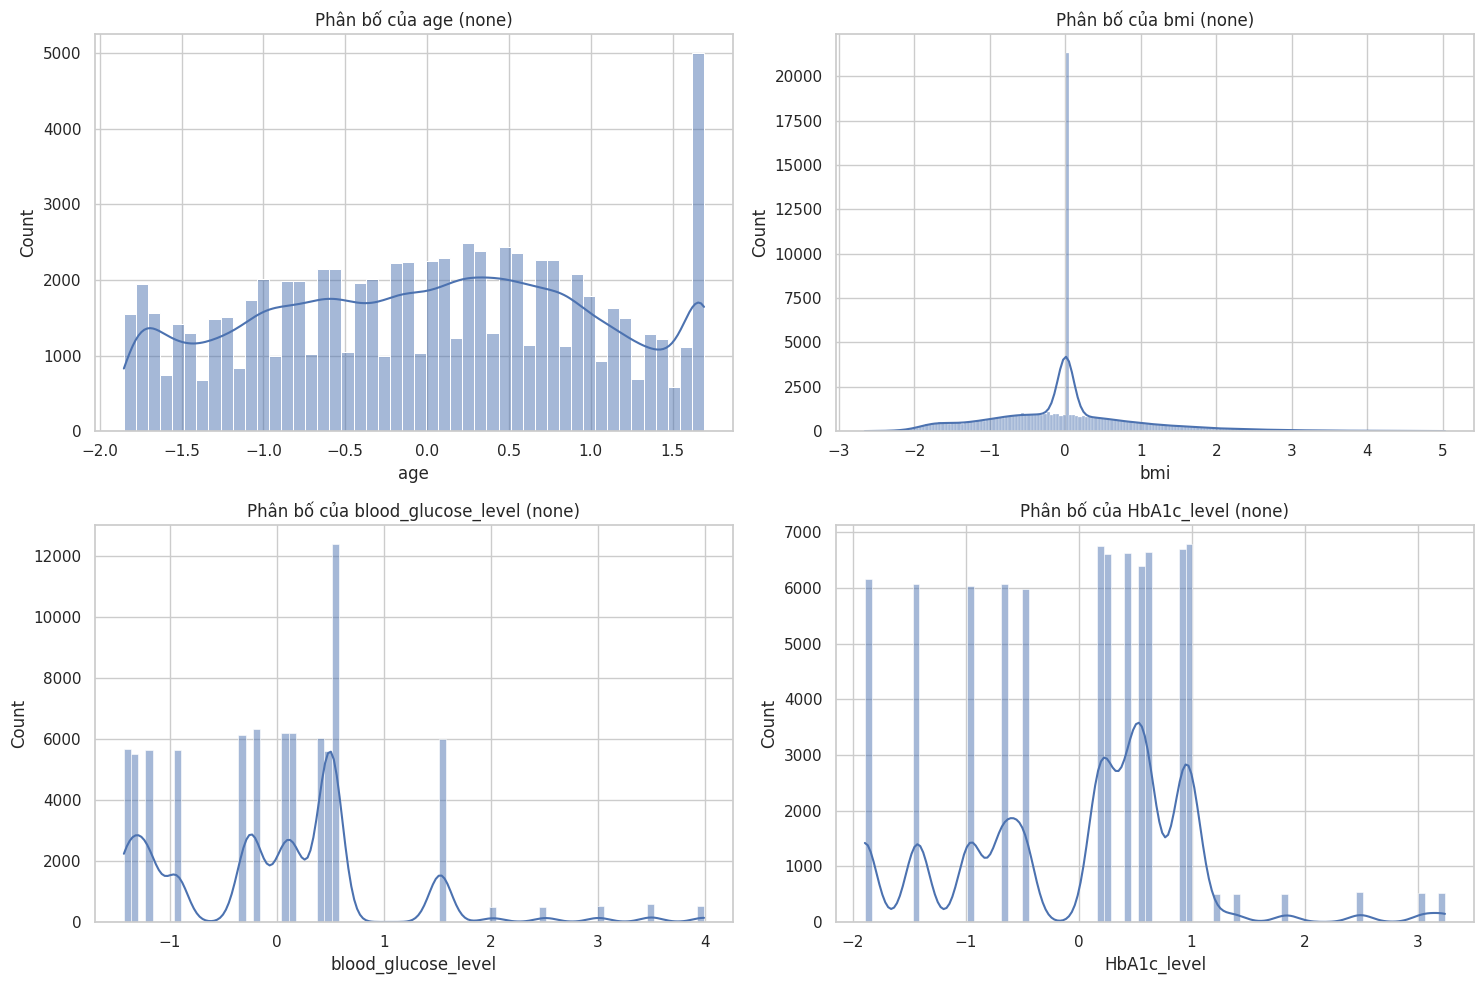

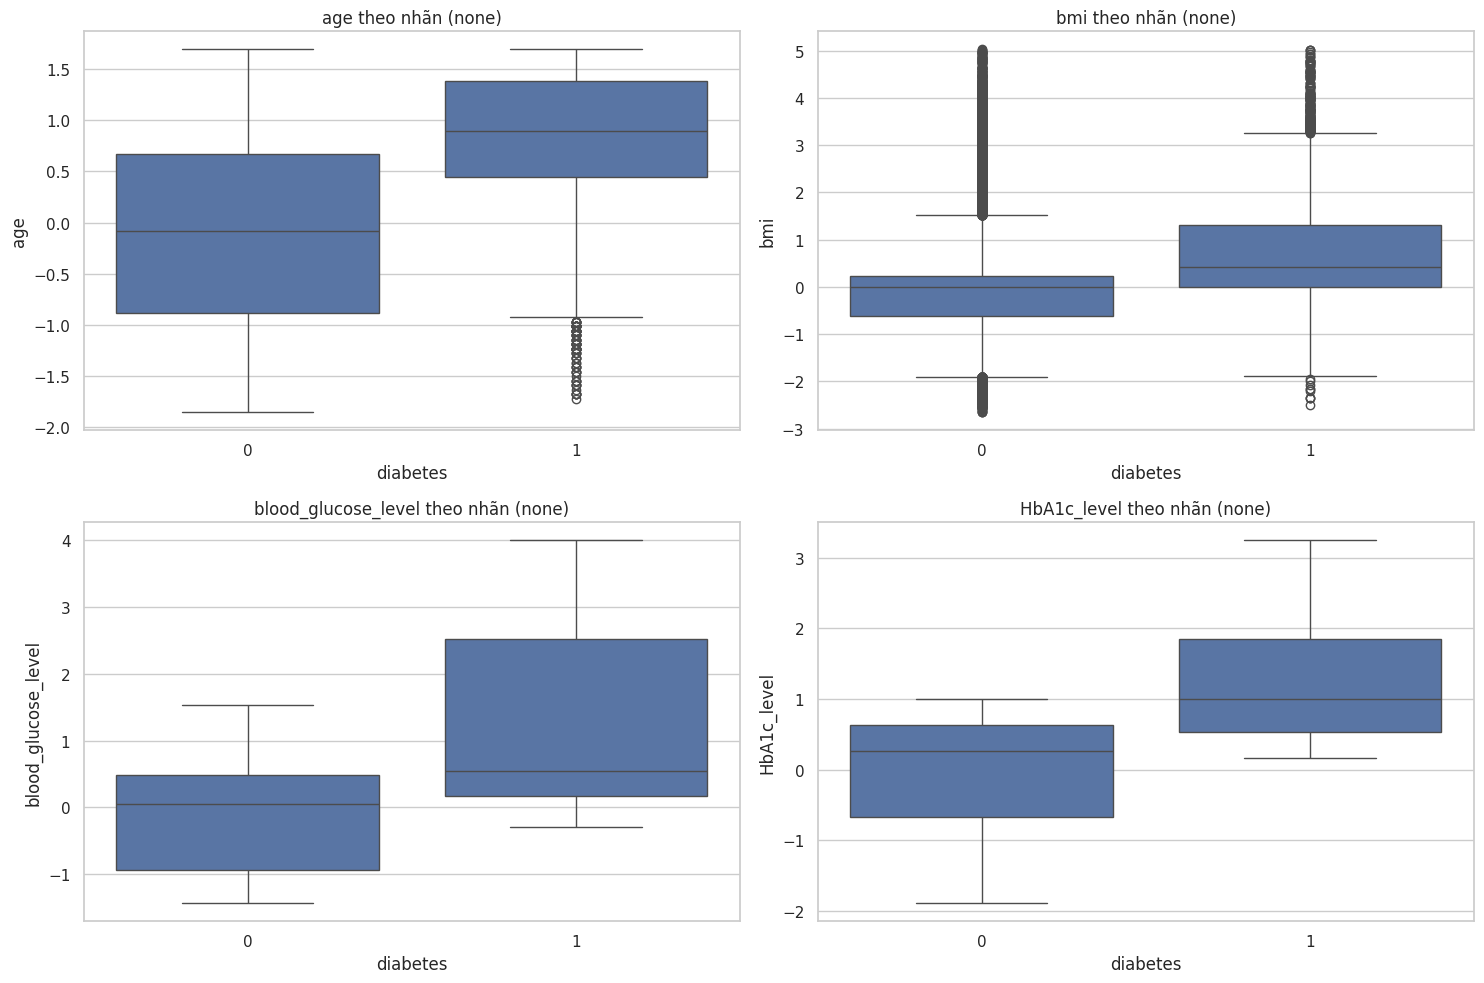

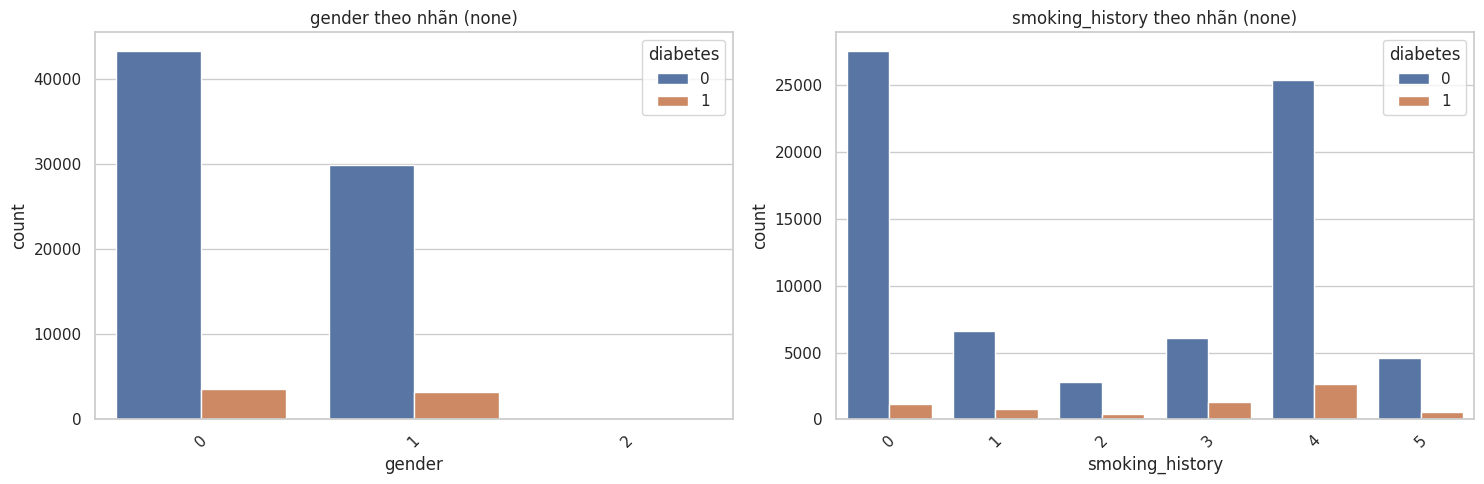


=== Trực Quan Hóa Dữ Liệu: SMOTE ===


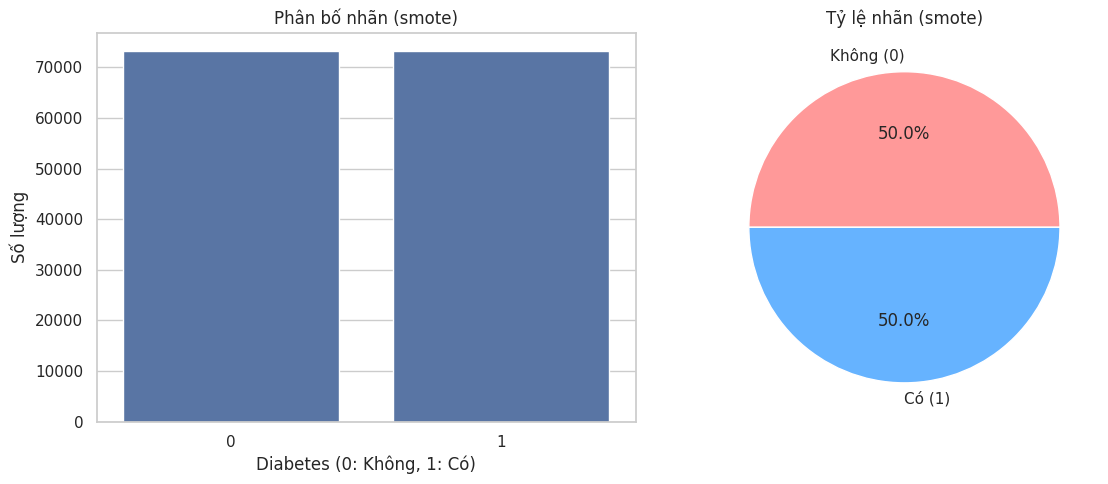

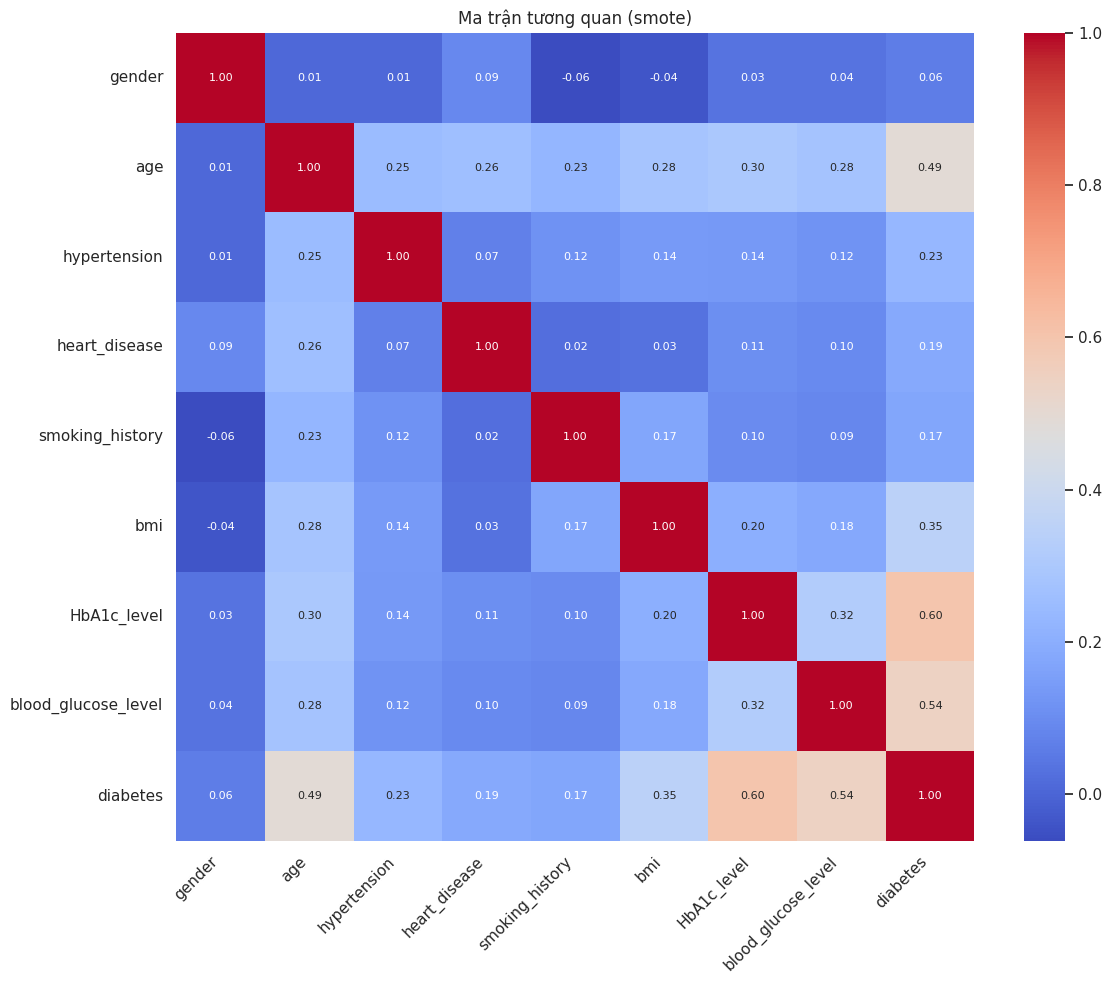

Các trường trong ma trận tương quan (smote):
['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']


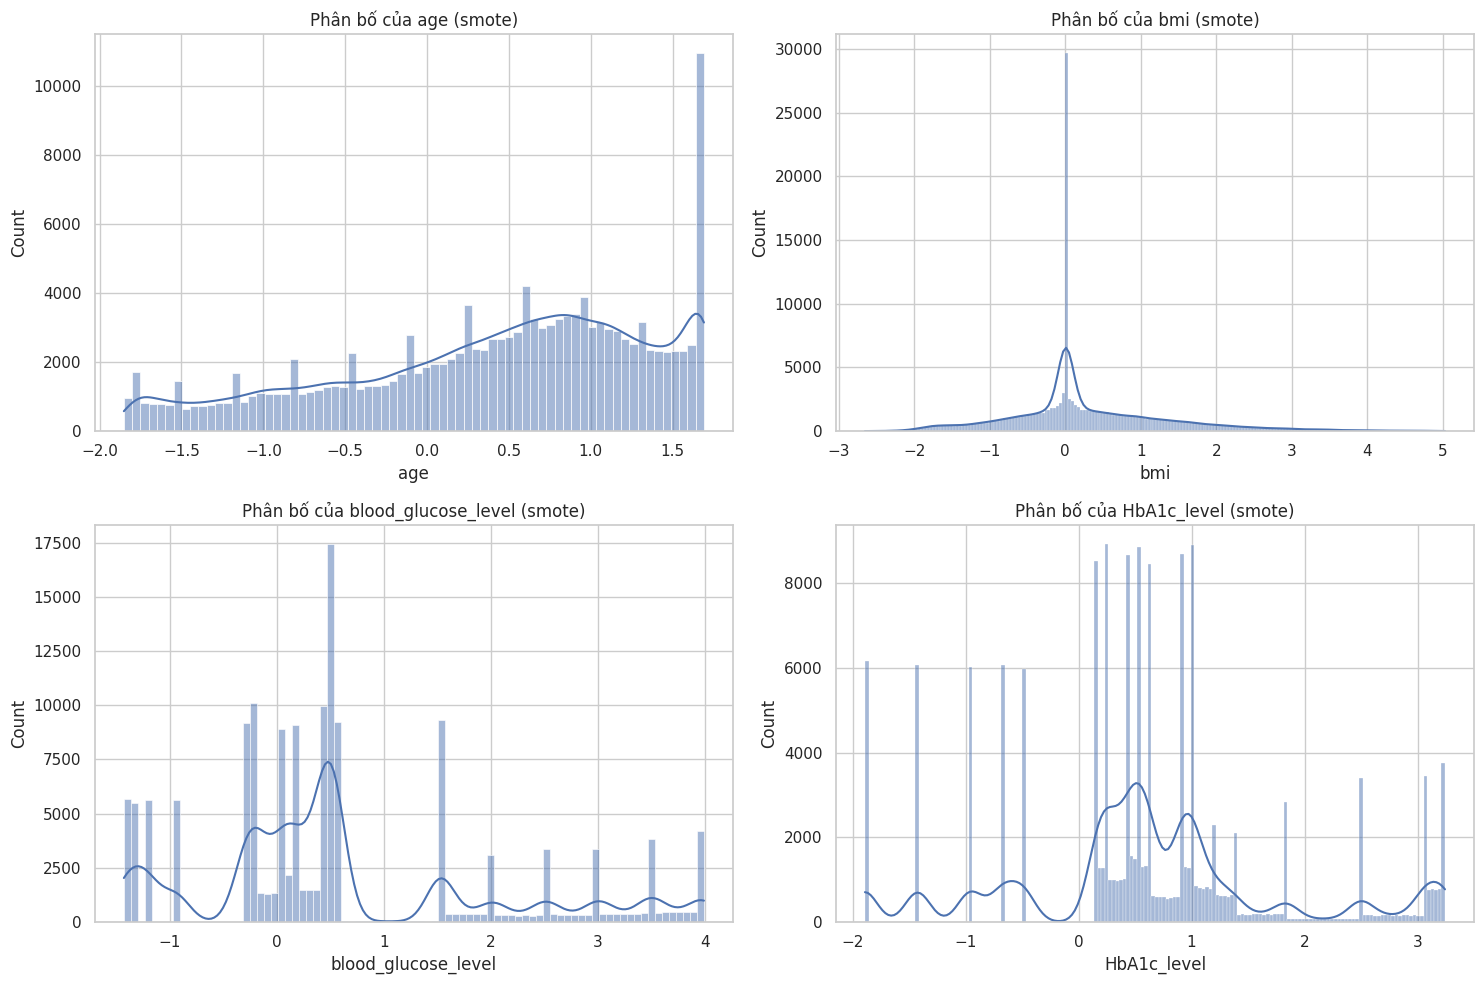

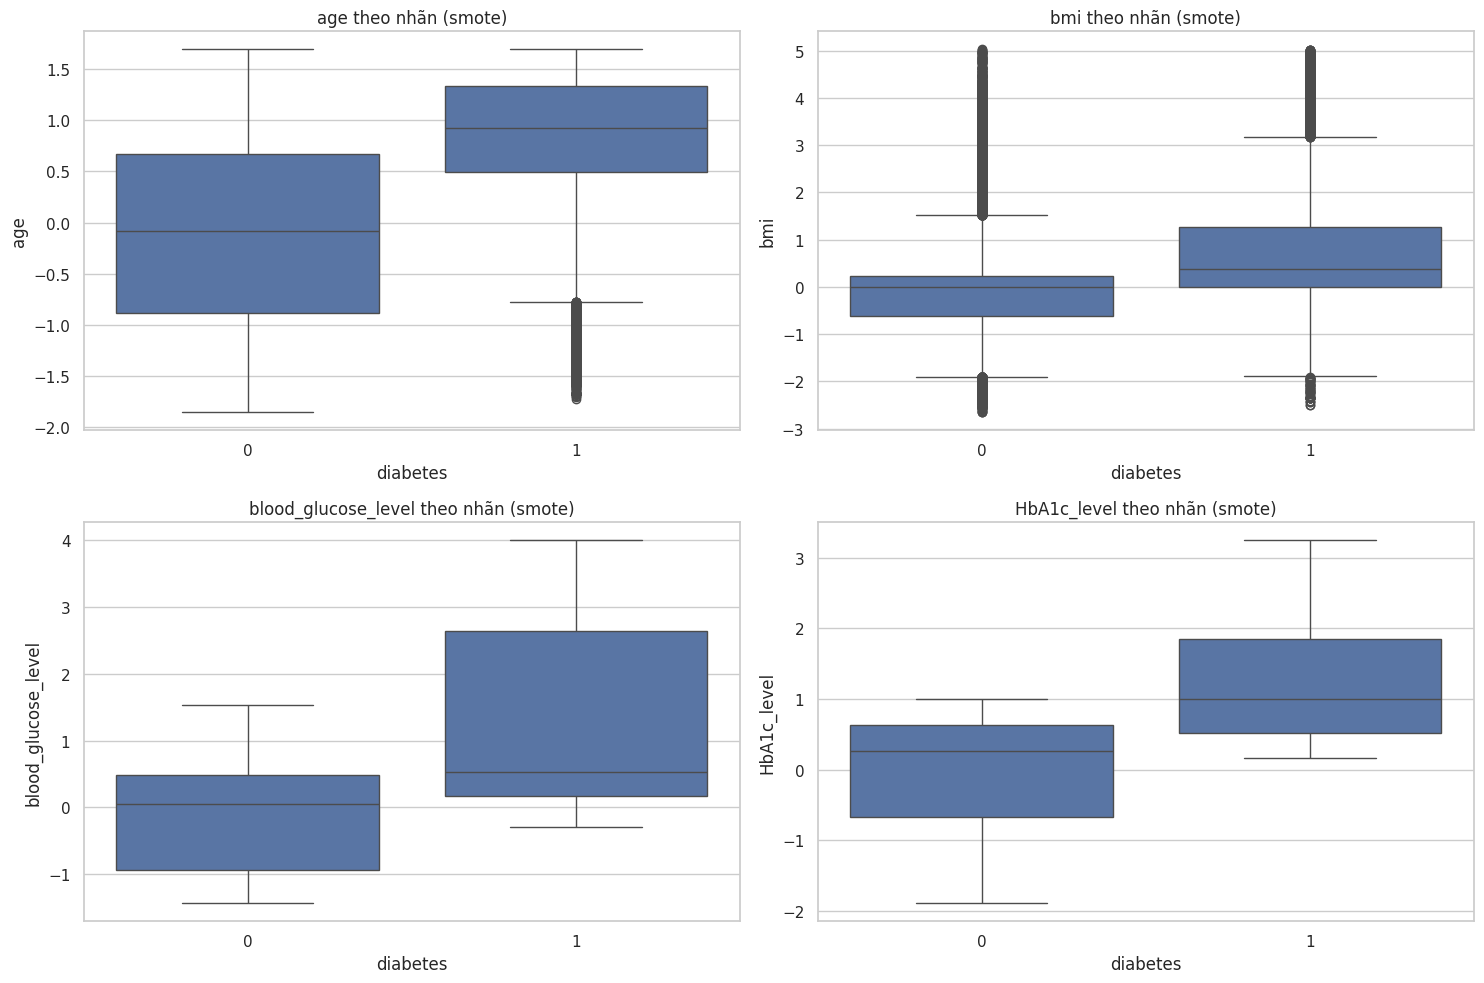

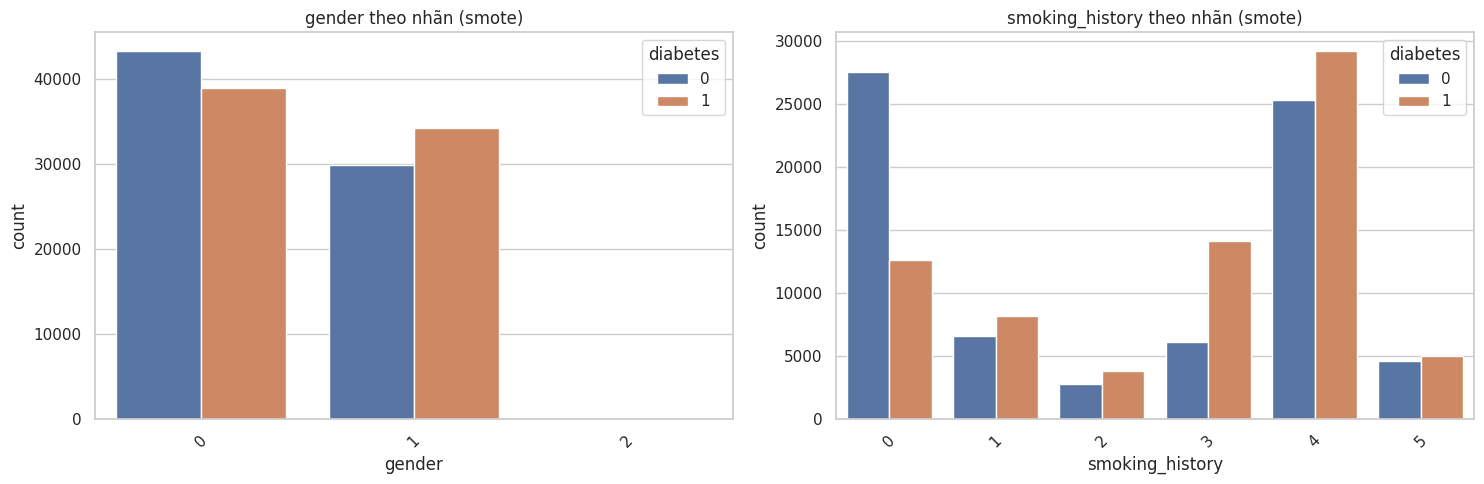


=== Trực Quan Hóa Dữ Liệu: SMOTE-ENN ===


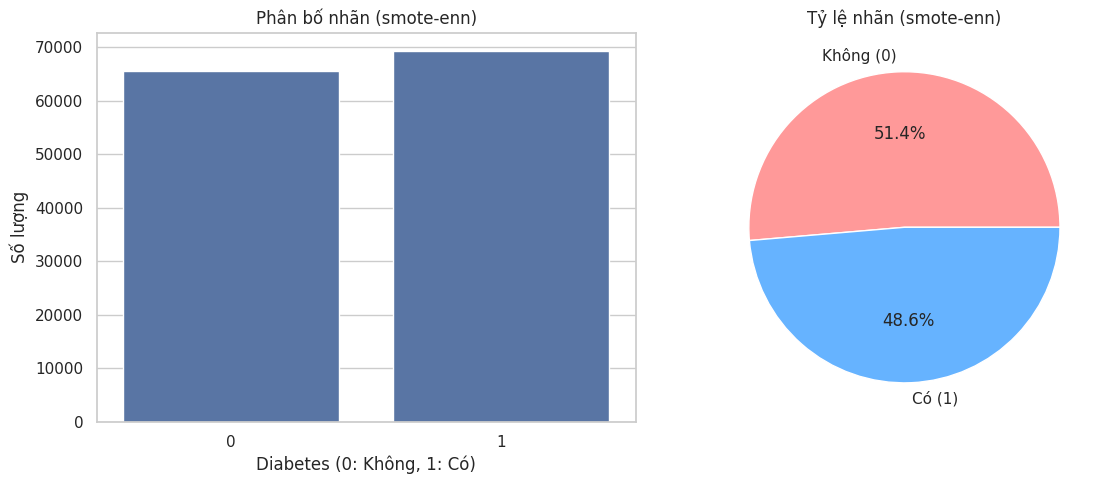

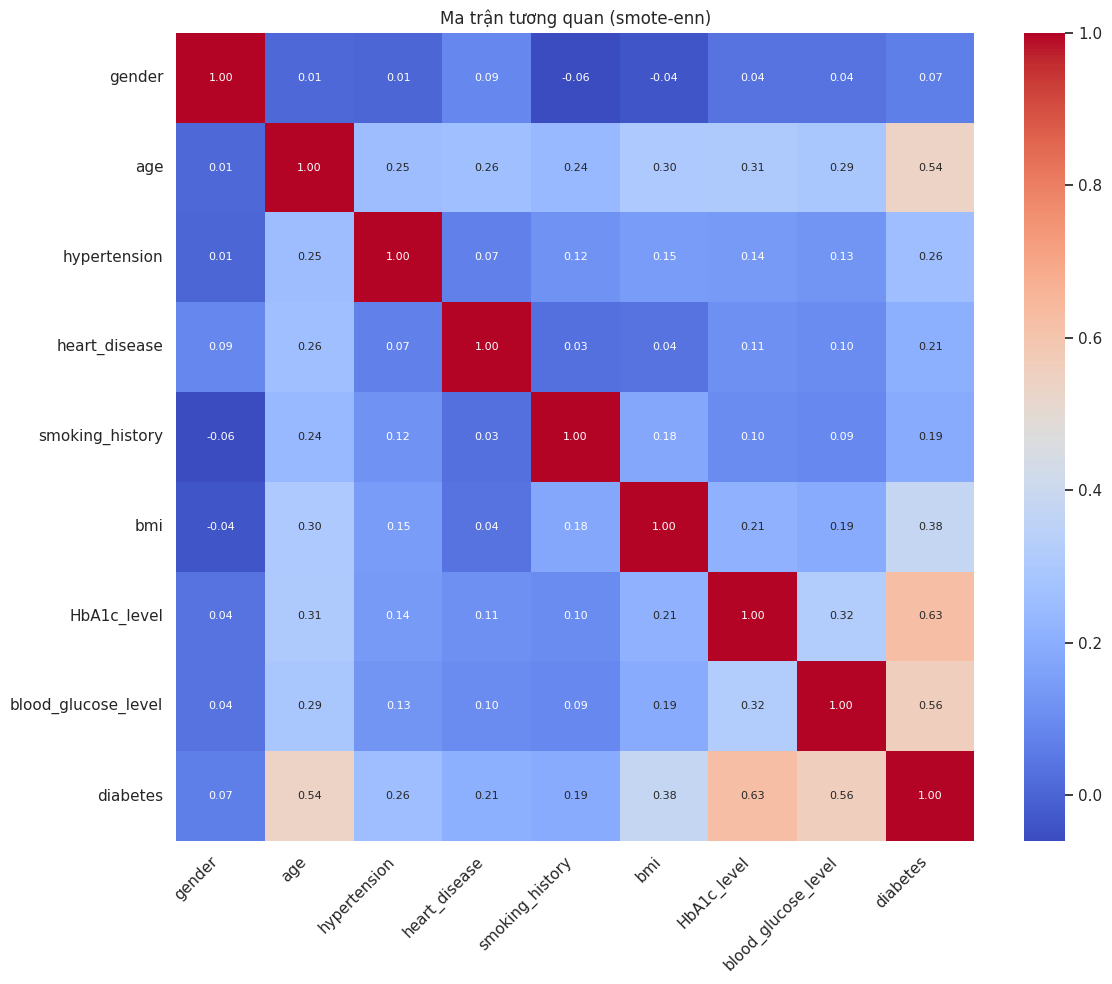

Các trường trong ma trận tương quan (smote-enn):
['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']


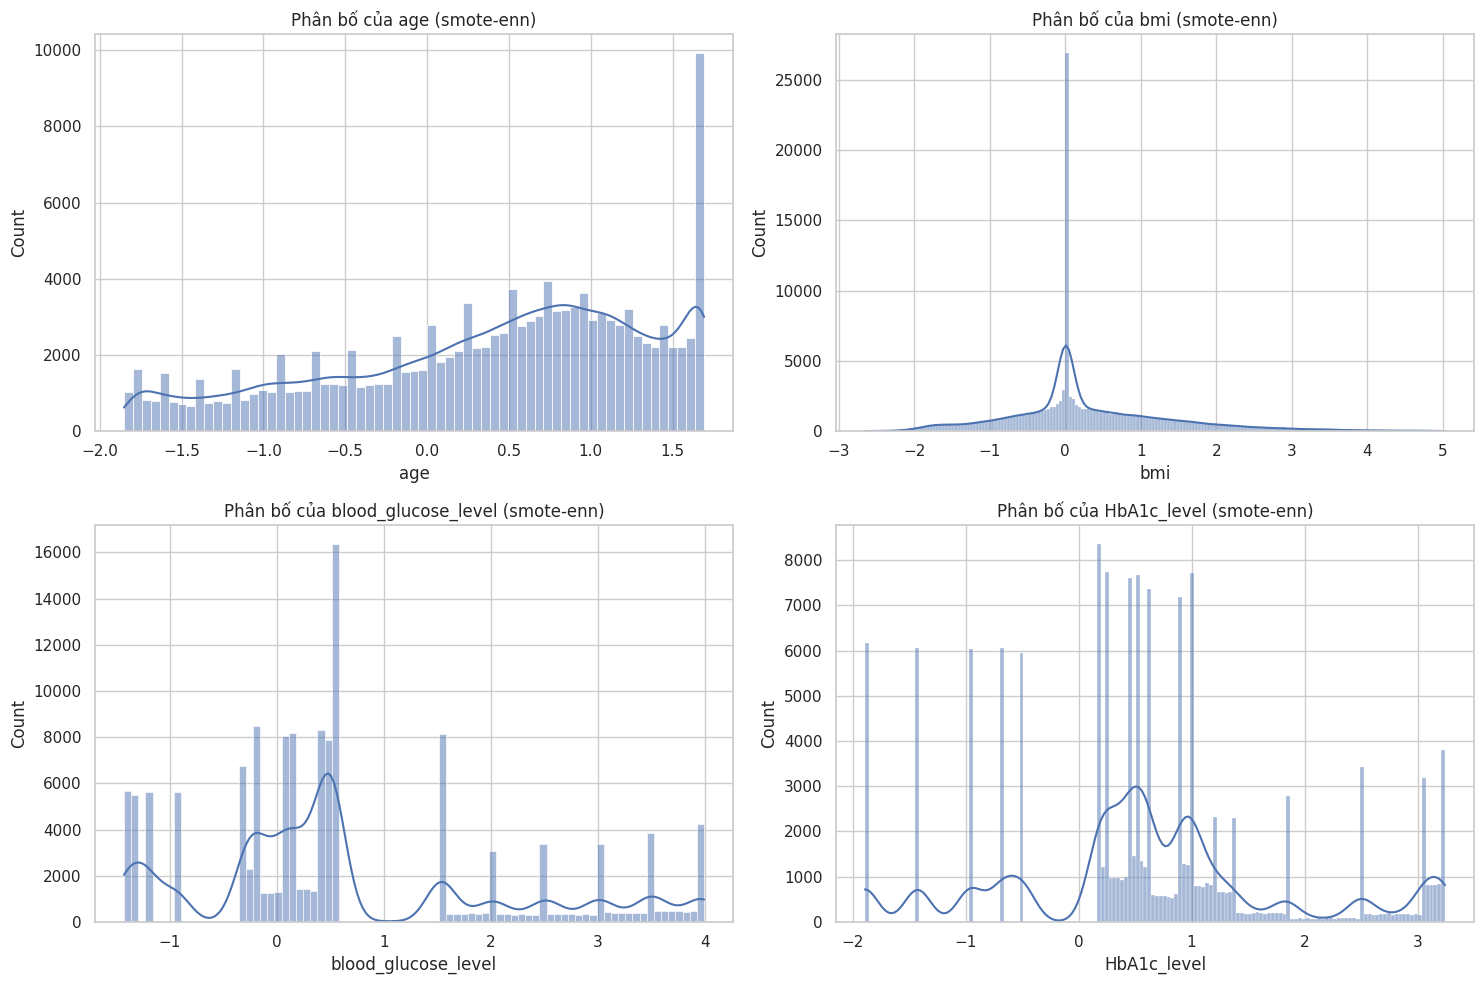

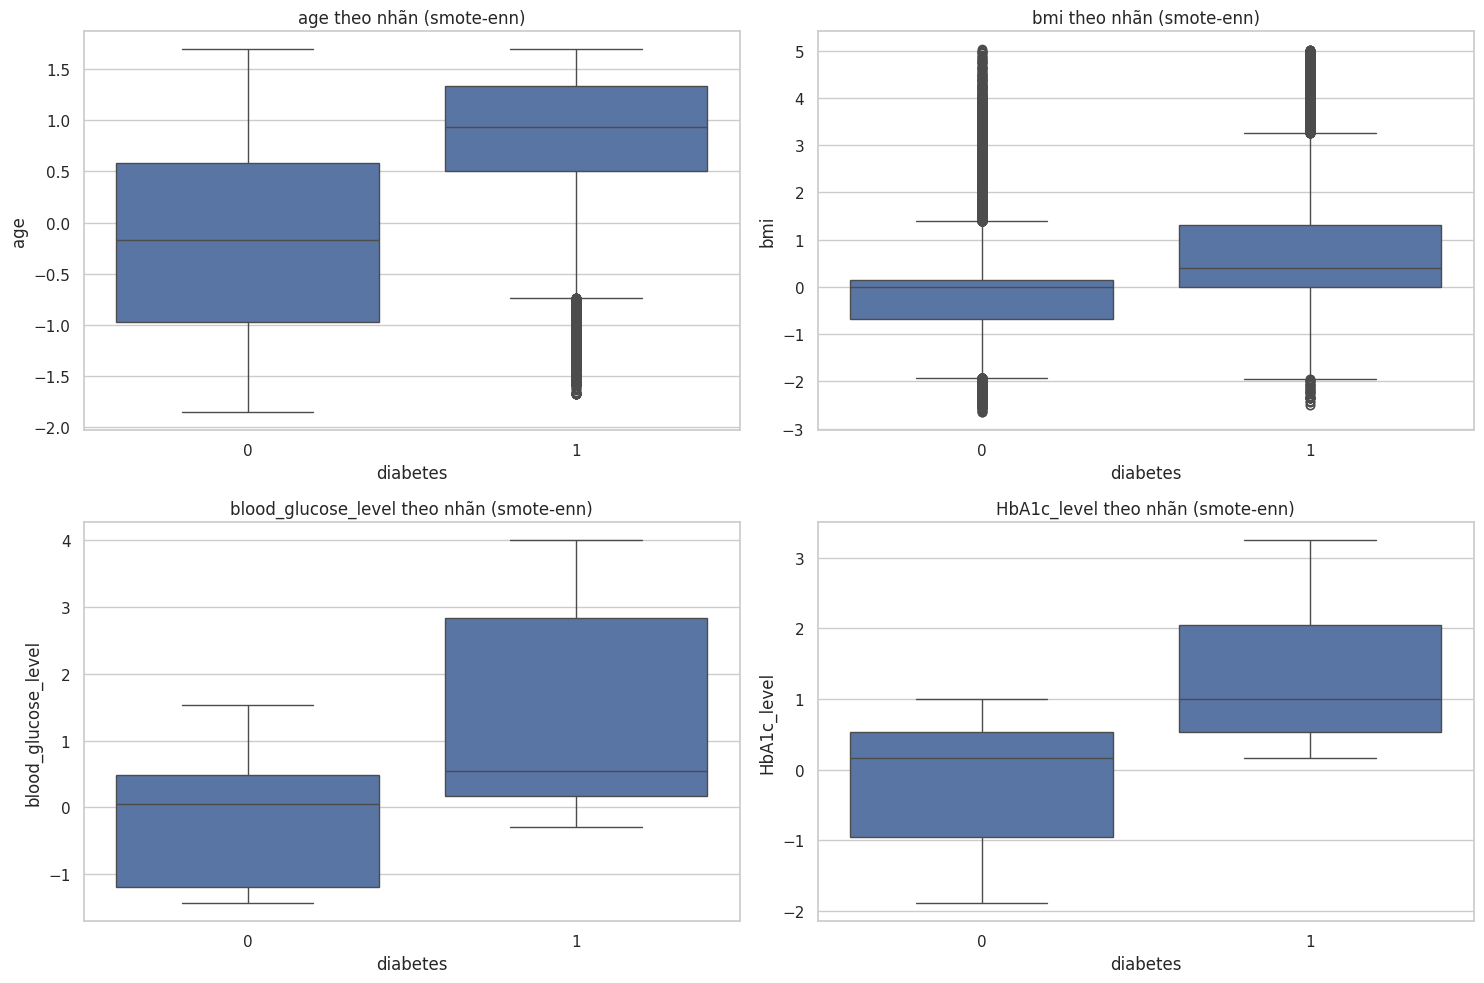

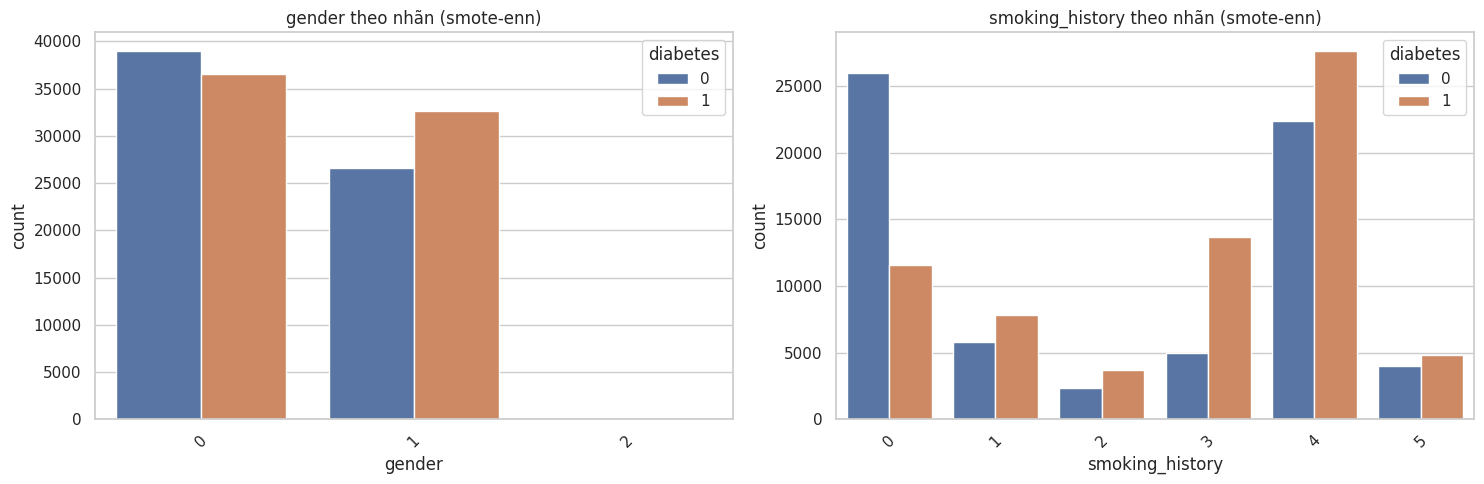


=== Trực Quan Hóa Dữ Liệu: BORDERLINE-SMOTE ===


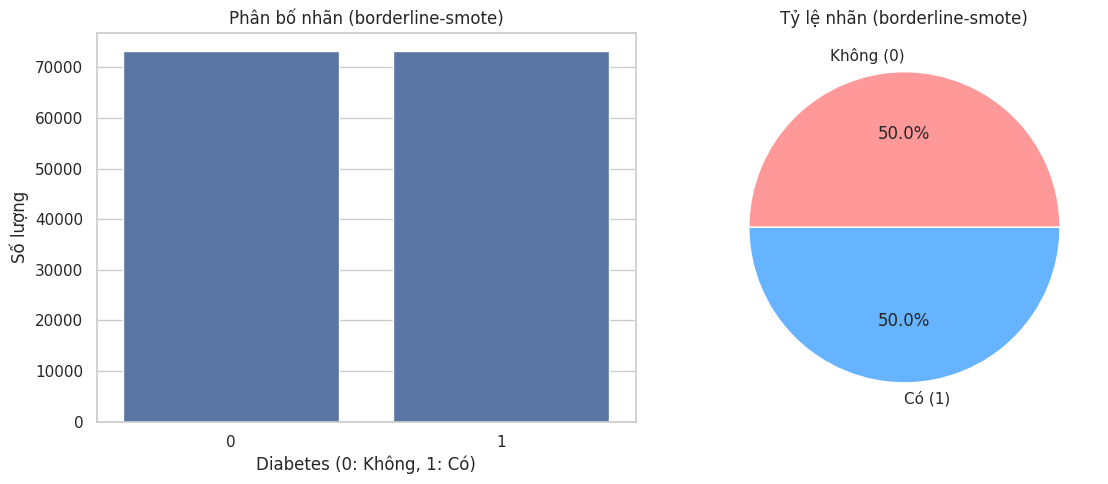

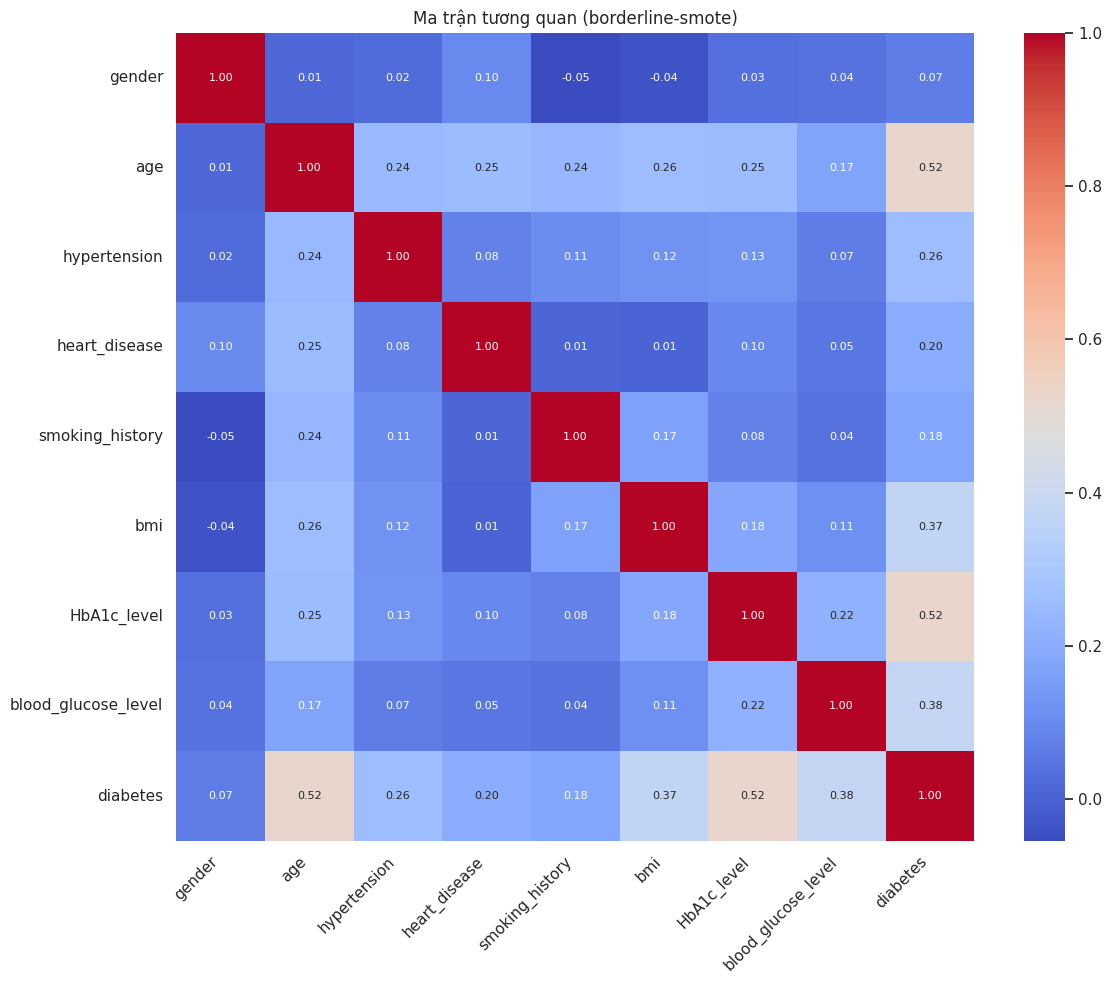

Các trường trong ma trận tương quan (borderline-smote):
['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']


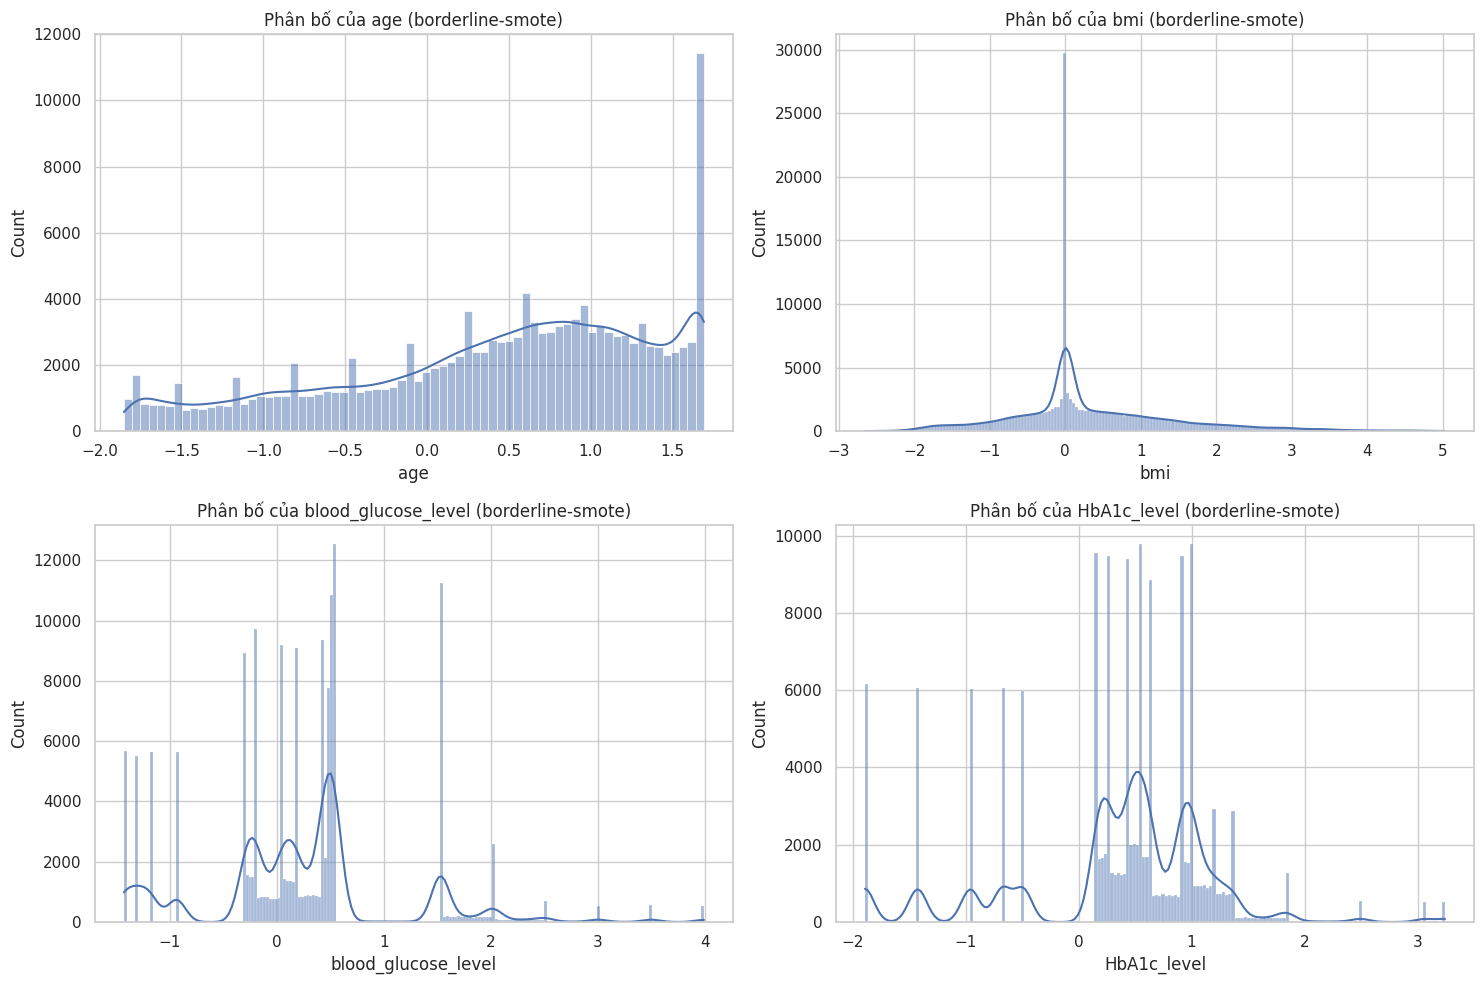

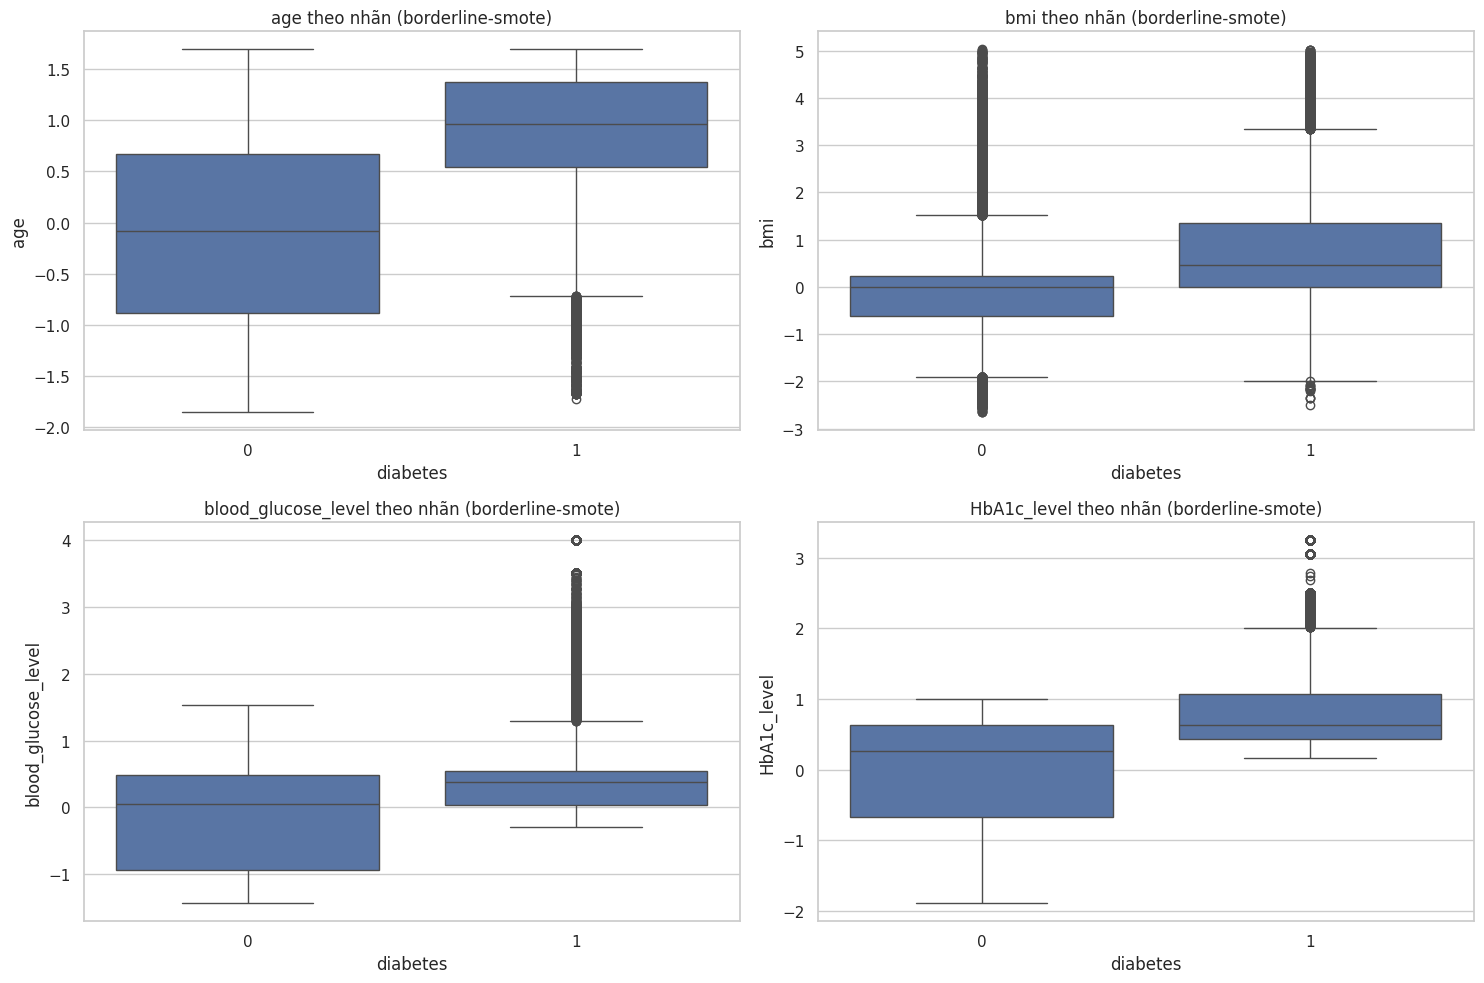

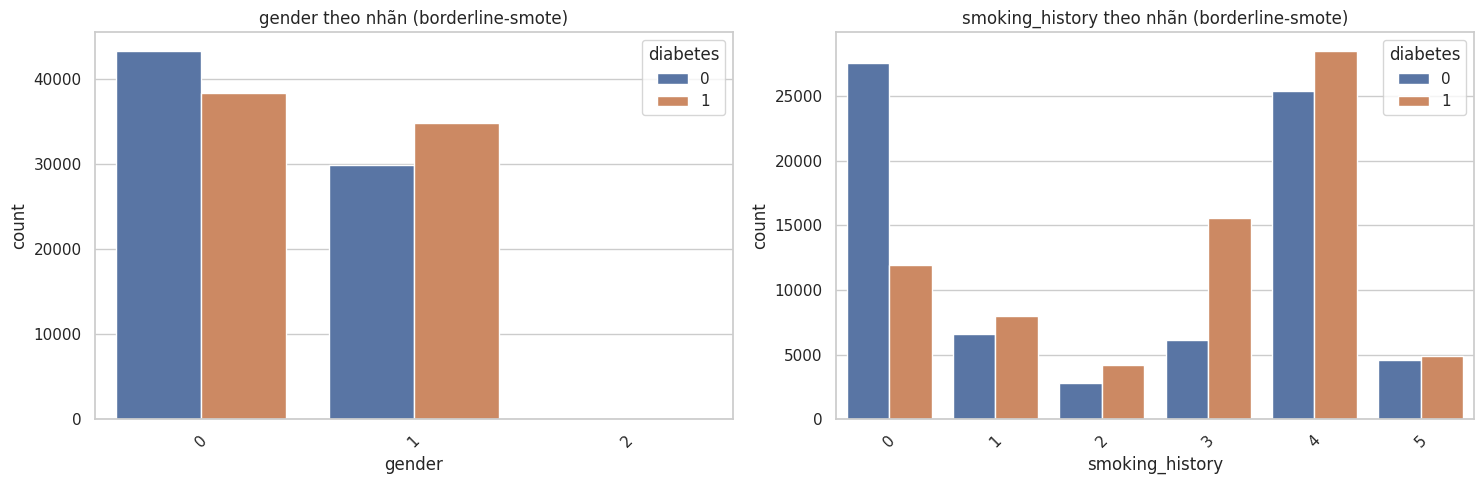

In [ ]:
# Hàm chuyển X_train_res và y_train_res thành DataFrame để trực quan hóa
def create_dataframe(X_train, y_train):
    df = pd.DataFrame(X_train, columns=X_train_base.columns)
    df['diabetes'] = y_train
    return df

# Trực quan hóa cho từng trạng thái
for state in states:
    print(f"\n=== Trực Quan Hóa Dữ Liệu: {state.upper()} ===")
    X_train_res, y_train_res = data_states[state]
    df_state = create_dataframe(X_train_res, y_train_res)

    # Phân bố nhãn
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(x='diabetes', data=df_state)
    plt.title(f'Phân bố nhãn ({state})')
    plt.xlabel('Diabetes (0: Không, 1: Có)')
    plt.ylabel('Số lượng')

    plt.subplot(1, 2, 2)
    df_state['diabetes'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Không (0)', 'Có (1)'], colors=['#ff9999', '#66b3ff'])
    plt.title(f'Tỷ lệ nhãn ({state})')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

    # Ma trận tương quan
    plt.figure(figsize=(12, 10))
    corr_matrix_state = df_state.corr()
    sns.heatmap(corr_matrix_state, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8})
    plt.title(f'Ma trận tương quan ({state})')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Kiểm tra các trường
    print(f"Các trường trong ma trận tương quan ({state}):")
    print(corr_matrix_state.columns.tolist())

    # Phân bố các đặc trưng số
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(2, 2, i)
        sns.histplot(df_state[col], kde=True)
        plt.title(f'Phân bố của {col} ({state})')
    plt.tight_layout()
    plt.show()

    # Mối quan hệ giữa đặc trưng số và nhãn
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(2, 2, i)
        sns.boxplot(x='diabetes', y=col, data=df_state)
        plt.title(f'{col} theo nhãn ({state})')
    plt.tight_layout()
    plt.show()

    # Mối quan hệ giữa đặc trưng phân loại và nhãn
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(categorical_cols, 1):
        plt.subplot(1, 2, i)
        sns.countplot(x=col, hue='diabetes', data=df_state)
        plt.title(f'{col} theo nhãn ({state})')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
# Hàm huấn luyện và tinh chỉnh mô hình
def train_models(X_train_res, y_train_res, y_train):
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
        'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
        'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
        # 'SVM': SVC(random_state=42, class_weight='balanced', probability=True),
        'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced')
    }

    scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
    models['XGBoost'] = xgb.XGBClassifier(
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        objective='binary:logistic',
        eval_metric='logloss'
    )

    param_grids = {
        'Logistic Regression': {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']},
        'K-Nearest Neighbors': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']},
        'Random Forest': {'n_estimators': [100, 200], 'max_depth': [10, 20, None]},
        # 'SVM': {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']},
        'Decision Tree': {'max_depth': [5, 10, 20], 'min_samples_split': [2, 5, 10]},
        'XGBoost': {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1]}
    }

    results = {}
    for name, model in models.items():
        print(f"\nTinh chỉnh {name}...")
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grids[name],
            scoring='recall',
            cv=5,
            n_jobs=-1,
            verbose=1
        )
        start_time = time.time()
        grid_search.fit(X_train_res, y_train_res)
        training_time = time.time() - start_time
        best_model = grid_search.best_estimator_
        print(f"Tham số tối ưu: {grid_search.best_params_}")
        results[name] = {'model': best_model, 'training_time': training_time}

    return results

# Huấn luyện mô hình cho từng trạng thái
all_results = {}
for state in states:
    print(f"\n=== Huấn luyện với dữ liệu: {state.upper()} ===")
    X_train_res, y_train_res = data_states[state]
    models = train_models(X_train_res, y_train_res, y_train_base)
    all_results[state] = {'models': models, 'X_test': X_test, 'y_test': y_test}


=== Huấn luyện với dữ liệu: NONE ===

Tinh chỉnh Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Tham số tối ưu: {'C': 0.1, 'solver': 'liblinear'}

Tinh chỉnh K-Nearest Neighbors...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Tham số tối ưu: {'n_neighbors': 3, 'weights': 'distance'}

Tinh chỉnh Random Forest...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Tham số tối ưu: {'max_depth': 10, 'n_estimators': 100}

Tinh chỉnh Decision Tree...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Tham số tối ưu: {'max_depth': 5, 'min_samples_split': 2}

Tinh chỉnh XGBoost...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Tham số tối ưu: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}

=== Huấn luyện với dữ liệu: SMOTE ===

Tinh chỉnh Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Tham số tối ưu: {'C': 0.1, 'solver': 'liblinear'}

Tinh chỉnh K-Nearest Neighbo

In [ ]:
# Hàm đánh giá mô hình
def evaluate_models(models, X_test, y_test):
    results = {}
    for name, model_info in models.items():
        model = model_info['model']
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        report = classification_report(y_test, y_pred, output_dict=True)
        roc_auc = roc_auc_score(y_test, y_prob)

        results[name] = {
            'Accuracy': report['accuracy'],
            'Recall (Class 1)': report['1']['recall'],
            'F1-score (Class 1)': report['1']['f1-score'],
            'ROC-AUC': roc_auc,
            'Training Time': model_info['training_time']
        }

    return pd.DataFrame(results).T

# Đánh giá và lưu kết quả
metrics = ['Accuracy', 'Recall (Class 1)', 'F1-score (Class 1)', 'ROC-AUC']
comparison_dfs = {}

for state in states:
    print(f"\n=== Kết quả với dữ liệu: {state.upper()} ===")
    models = all_results[state]['models']
    X_test = all_results[state]['X_test']
    y_test = all_results[state]['y_test']
    results_df = evaluate_models(models, X_test, y_test)
    print(results_df)
    all_results[state]['results_df'] = results_df

# Tạo bảng so sánh tổng hợp
for metric in metrics:
    comparison_data = {}
    for state in states:
        comparison_data[state] = all_results[state]['results_df'][metric]
    comparison_dfs[metric] = pd.DataFrame(comparison_data)

# In bảng so sánh
for metric, df in comparison_dfs.items():
    print(f"\n=== So sánh {metric} ===")
    print(df)


=== Kết quả với dữ liệu: NONE ===
                     Accuracy  Recall (Class 1)  F1-score (Class 1)   ROC-AUC  \
Logistic Regression  0.886670          0.885294            0.570724  0.961265   
K-Nearest Neighbors  0.955749          0.638235            0.710544  0.878557   
Random Forest        0.901687          0.901765            0.609543  0.976156   
Decision Tree        0.821244          0.962941            0.478305  0.961594   
XGBoost              0.867347          0.935882            0.545610  0.974532   

                     Training Time  
Logistic Regression       4.776843  
K-Nearest Neighbors      26.242191  
Random Forest           126.135440  
Decision Tree             4.359092  
XGBoost                  32.131258  

=== Kết quả với dữ liệu: SMOTE ===
                     Accuracy  Recall (Class 1)  F1-score (Class 1)   ROC-AUC  \
Logistic Regression  0.887421          0.886471            0.572677  0.961142   
K-Nearest Neighbors  0.912049          0.805882           

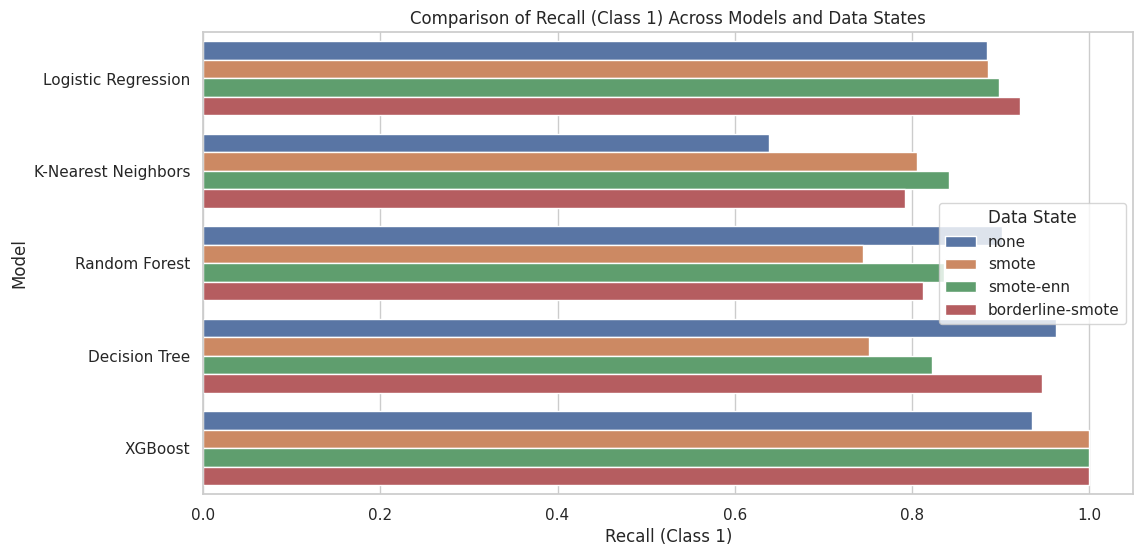

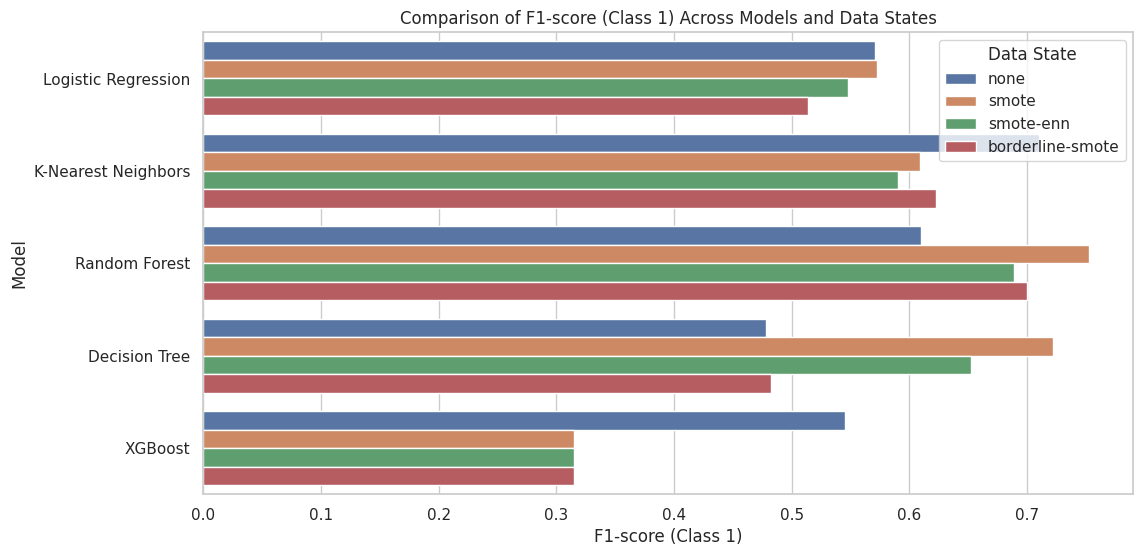

In [ ]:
# Hàm trực quan hóa
def visualize_resampling_comparison(comparison_df, metric):
    comparison_df_melted = comparison_df.reset_index().melt(id_vars='index', var_name='State', value_name=metric)
    comparison_df_melted.rename(columns={'index': 'Model'}, inplace=True)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=metric, y='Model', hue='State', data=comparison_df_melted)
    plt.title(f'Comparison of {metric} Across Models and Data States')
    plt.xlabel(metric)
    plt.ylabel('Model')
    plt.legend(title='Data State')
    plt.show()

# Vẽ biểu đồ
for metric in ['Recall (Class 1)', 'F1-score (Class 1)']:
    visualize_resampling_comparison(comparison_dfs[metric], metric)

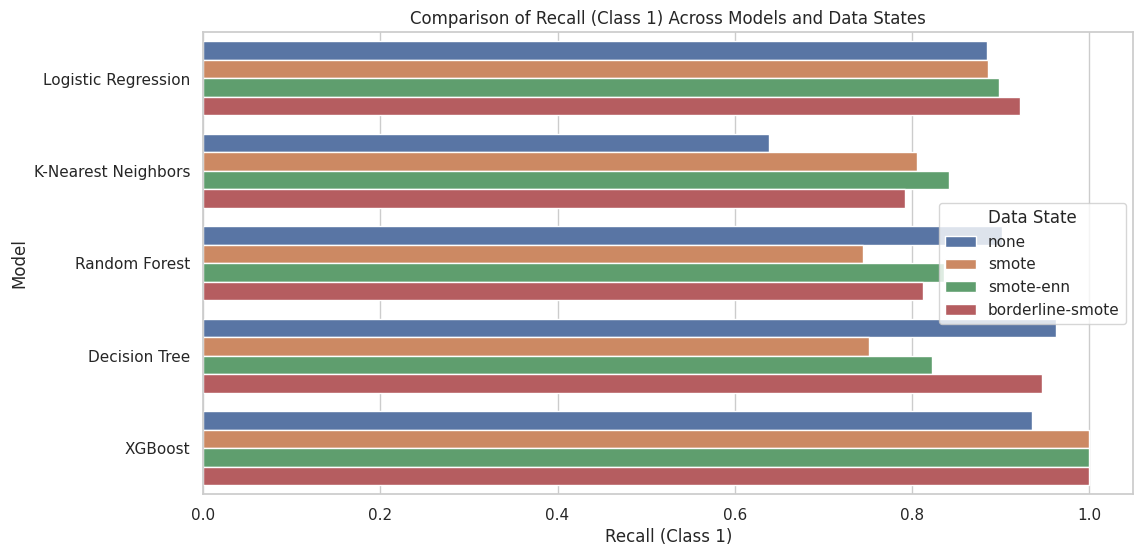

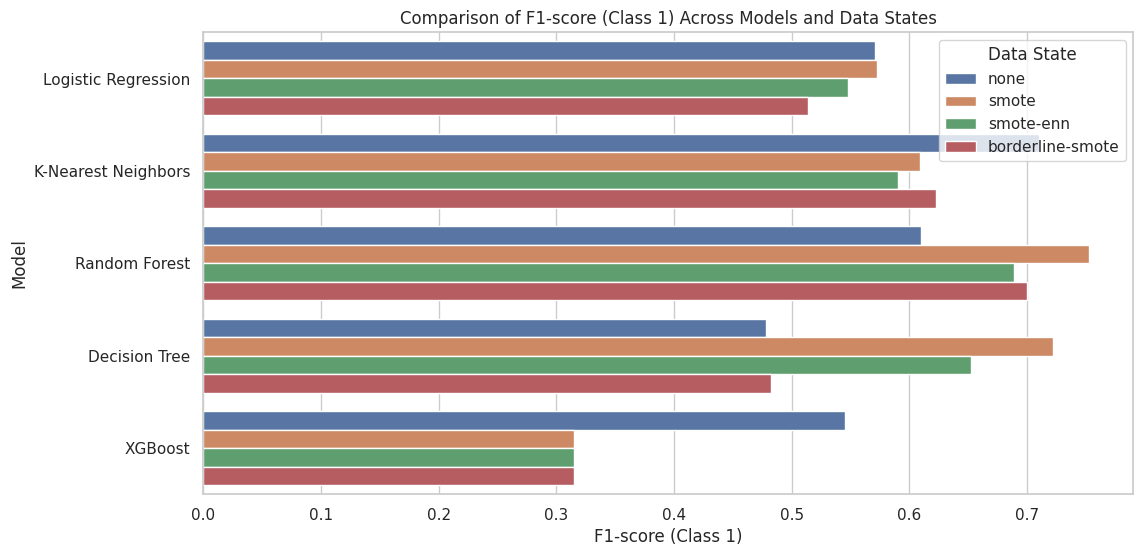

In [ ]:
# Lưu bảng so sánh
for metric, df in comparison_dfs.items():
    df.to_csv(f'/content/drive/My Drive/comparison_{metric.lower().replace(" ", "_")}.csv')

# Lưu biểu đồ
for metric in ['Recall (Class 1)', 'F1-score (Class 1)']:
    comparison_df = comparison_dfs[metric]
    comparison_df_melted = comparison_df.reset_index().melt(id_vars='index', var_name='State', value_name=metric)
    comparison_df_melted.rename(columns={'index': 'Model'}, inplace=True)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=metric, y='Model', hue='State', data=comparison_df_melted)
    plt.title(f'Comparison of {metric} Across Models and Data States')
    plt.xlabel(metric)
    plt.ylabel('Model')
    plt.legend(title='Data State')
    plt.savefig(f'/content/drive/My Drive/comparison_{metric.lower().replace(" ", "_")}.png')
    plt.show()